# CESM Historical Runs 1901-2014

# Setup

## Packages

In [1]:
%load_ext watermark

import numpy as np
import xarray as xr
import pandas as pd
import xcdat as xc
import intake

import matplotlib as mpl
import matplotlib.pyplot as plt

import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import regionmask

import cmocean.cm as cmo

%watermark -iv

xcdat     : 0.6.0
sys       : 3.11.6 | packaged by conda-forge | (main, Oct  3 2023, 10:40:35) [GCC 12.3.0]
intake    : 0.0.0
pandas    : 2.2.0
cartopy   : 0.22.0
xarray    : 2023.10.1
matplotlib: 3.8.0
numpy     : 1.24.4
cmocean   : 3.0.3
regionmask: 0.11.0



## Figure settings

In [2]:
mpl.rcParams["figure.dpi"] = 300
%config InlineBackend.figure_formats = ["png"]  # raster, transparent background -> best for publication of large, dense figures

# Load tree ring coordinates

In [3]:
tree_ring_coords = pd.read_csv('./latlon_gym_ang.csv', usecols=[0,1,2])

# Tree type classification: 0=gym, 1=ang, 2=none
tree_ring_coords = tree_ring_coords.rename(columns={'gym=0/ang=1': 'isAng'})
tree_ring_coords = tree_ring_coords.replace({'isAng': np.nan}, 2)

ang_coords = tree_ring_coords.loc[tree_ring_coords['isAng']==1].drop(columns='isAng')
gym_coords = tree_ring_coords.loc[tree_ring_coords['isAng']==0].drop(columns='isAng')

In [4]:
tree_ring_coords

lat         lon  isAng
0   -38.716000  -71.700000    0.0
1   -38.428000  -71.538000    0.0
2   -33.051000  120.795000    0.0
3   -22.851389  118.627778    0.0
4   -22.851000  117.628000    0.0
..         ...         ...    ...
428  45.750759    6.191114    2.0
429  45.820000 -121.952000    0.0
430  47.210000   11.452000    0.0
431  48.472690  -79.330129    0.0
432  50.400000   87.550000    0.0

[433 rows x 3 columns]

In [13]:
row['isAng']

0.0

Text(0.05, 0.525, 'angiosperm')

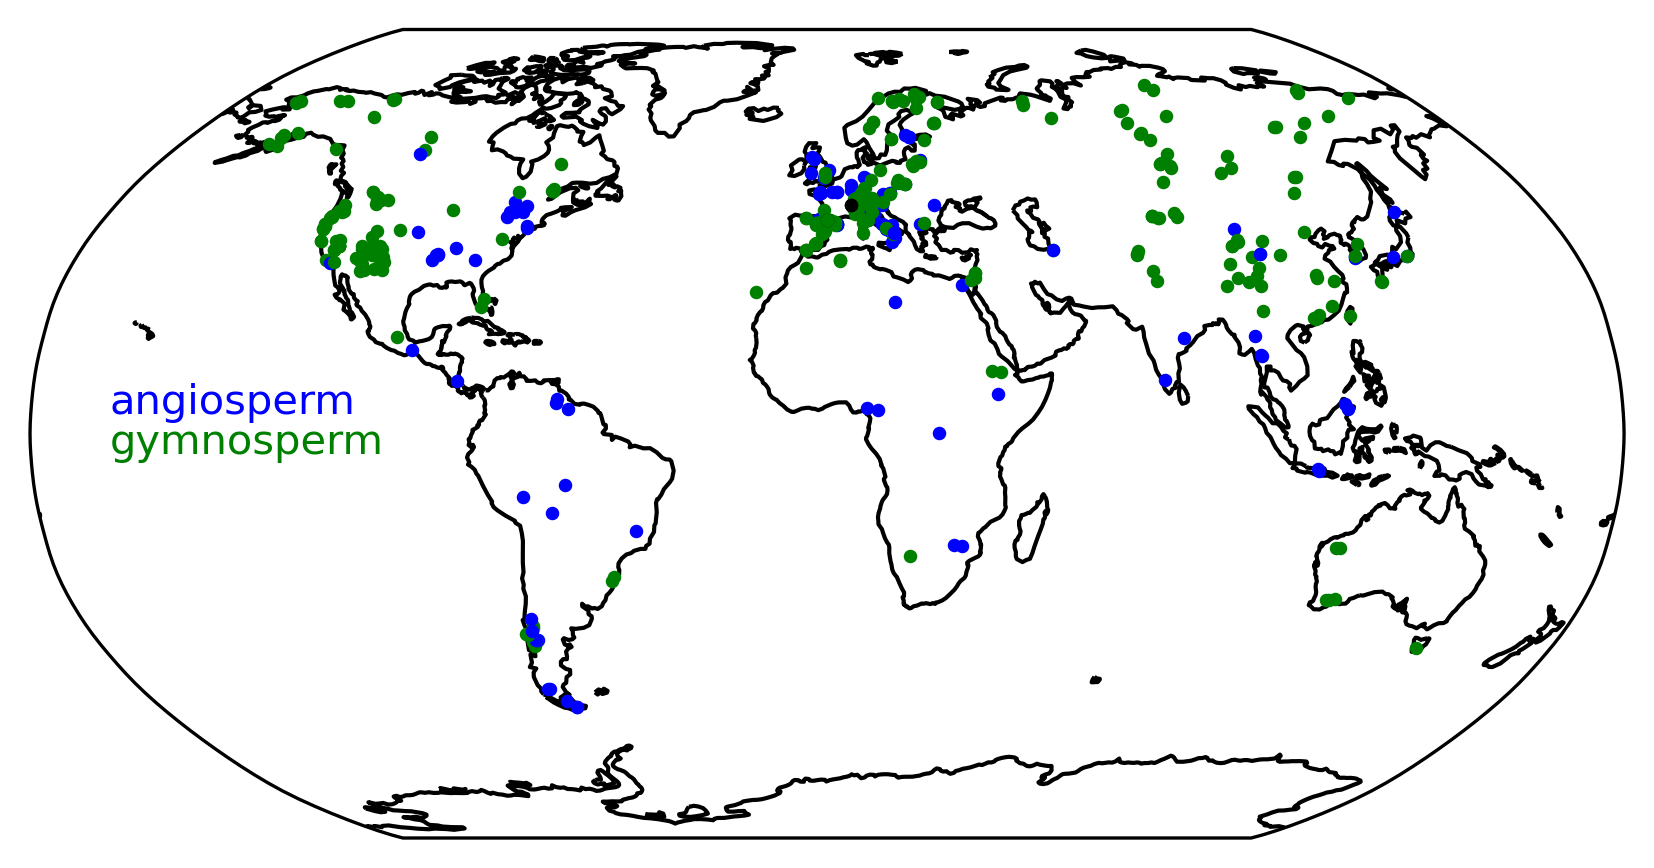

In [16]:
fig, ax = plt.subplots(
    figsize=(8,3.5),
    subplot_kw={'projection': ccrs.Robinson()},
)

c = ['green', 'blue', 'black']
m = ['x', '+', 'o']

for i, row in tree_ring_coords.iterrows():
    ax.scatter(
        row['lon'], row['lat'],
        s=5, color=c[int(row['isAng'])],
        transform=ccrs.PlateCarree()
    )

ax.set_extent((-180, 180, -90, 90))
ax.coastlines(zorder=0)

ax.text(0.05, 0.475, 'gymnosperm', ha='left', color='green', transform=ax.transAxes)
ax.text(0.05, 0.525, 'angiosperm', ha='left', color='blue', transform=ax.transAxes)

Text(0.5, 1.0, 'Tree ring sites (ang.=blue, gym.=green)')

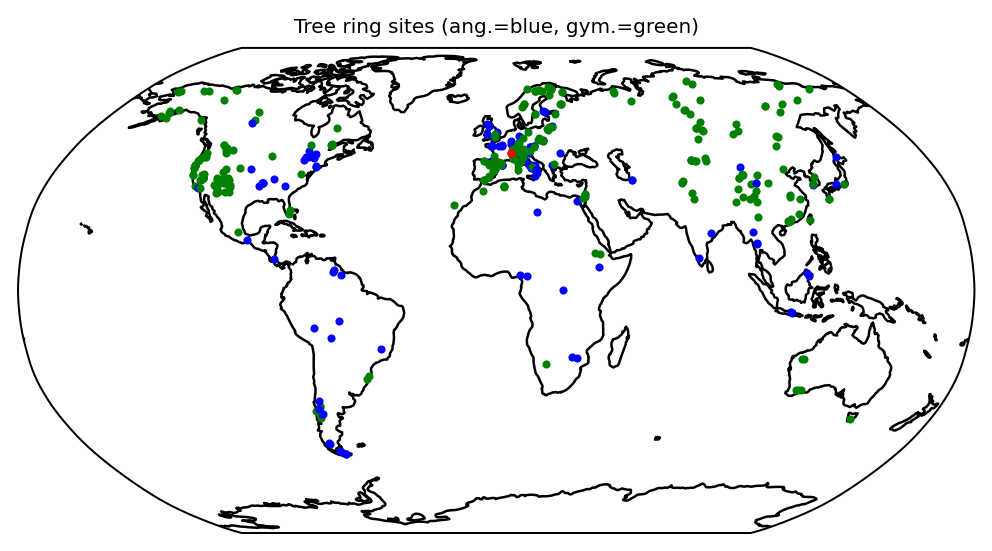

In [28]:
fig, ax = plt.subplots(
    figsize=(8,3.5),
    subplot_kw={'projection': ccrs.Robinson()},
)

c = ['green', 'blue', 'black']
m = ['x', '+', 'o']

for i, row in tree_ring_coords.iterrows():
    ax.scatter(
        row['lon'], row['lat'],
        s=5, color=c[int(row['isAng'])],
        # marker=m[int(row['isAng'])], linewidth=1,
        transform=ccrs.PlateCarree()
    )

ax.set_extent((-180, 180, -90, 90))
ax.coastlines(zorder=0)
ax.set_title('Tree ring sites (ang.=blue, gym.=green)', fontsize=8)

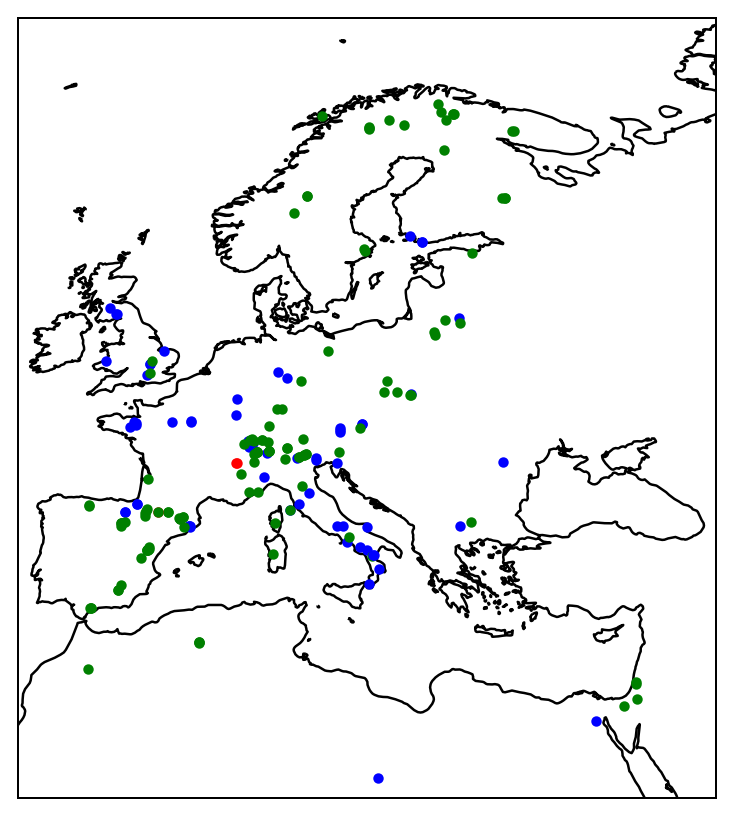

In [29]:
fig, ax = plt.subplots(
    figsize=(5,6),
    subplot_kw={'projection': ccrs.Robinson()},
)

c = ['green', 'blue', 'red']

for index, row in tree_ring_coords.iterrows():
    ax.scatter(
        row['lon'], row['lat'],
        s=10, color=c[int(row['isAng'])],
        transform=ccrs.PlateCarree()
    )

ax.set_extent((-10, 40, 25, 75))
ax.coastlines(resolution='50m', zorder=0)

# Load gridded PFT-level historical simulations

In [4]:
def format_ds_coords(ds):
    ds = ds.bounds.add_bounds('X')
    ds = ds.bounds.add_bounds('Y')
    ds = xc.swap_lon_axis(ds, (-180, 180))
    return ds

gssunln = xc.open_dataset('/glade/work/bbuchovecky/WUE_analysis/clm50_cesm23a02cPPEn08ctsm51d030_1deg_GSWP3V1_hist.clm2.h1.GSSUNLN.185001-201412_gridded.nc')
gpp = xc.open_dataset('/glade/work/bbuchovecky/WUE_analysis/clm50_cesm23a02cPPEn08ctsm51d030_1deg_GSWP3V1_hist.clm2.h1.GPP.185001-201412_gridded.nc')

gssunln = format_ds_coords(gssunln)
gpp = format_ds_coords(gpp)

gssunln = gssunln['GSSUNLN']
gpp = gpp['GPP']

In [5]:
# My rough understanding is needleleaf~gymnosperm and broadleaf~angiosperm

tree_pft = gssunln['vegtype'][1:9]
tree_pft_names = gssunln['vegtype_name'][1:9]
tree_pft_is_ang = np.array([0, 0, 0, 1, 1, 1, 1, 1])

noncrop_pft = gssunln['vegtype'][1:15]
noncrop_pft_names = gssunln['vegtype_name'][1:15]
noncrop_pft_is_ang = np.array([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

# Subselect historical simulations for the location of the tree ring sites

In [6]:
def select_site_from_gridded_data(xr_data, df_site_data, do_time=True, do_coords=True):
    assert do_time or do_coords
    nsite = df_site_data.iloc[:,0].size
    np_site_data = np.empty((nsite), dtype=xr.DataArray)

    for i, row in df_site_data.iterrows():
        # Select the grid box nearest to the site coordinates
        if do_coords:
            gridbox_timeseries = xr_data.sel(lat=row['lat'], lon=row['lon'], method='nearest')

        # Select the time period of the site (if observational data)
        if do_time:
            gridbox_timeseries = gridbox_timeseries.sel(time=slice(row['start_date'], row['end_date']))

        np_site_data[i] = gridbox_timeseries
    
    return np_site_data


gssunln_sites = select_site_from_gridded_data(gssunln, tree_ring_coords, do_time=False)
gpp_sites = select_site_from_gridded_data(gpp, tree_ring_coords, do_time=False)

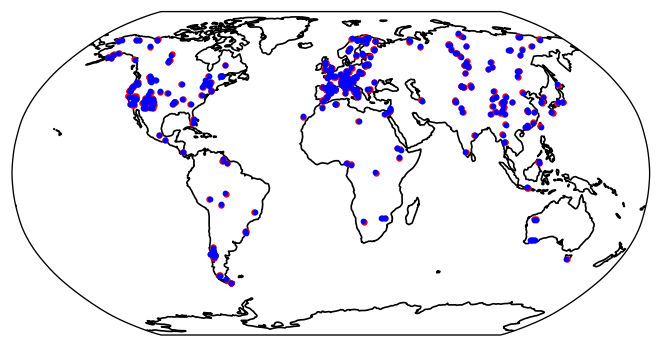

In [18]:
fig, ax = plt.subplots(
    figsize=(8,3.5),
    subplot_kw={'projection': ccrs.Robinson()},
)

for i, row in tree_ring_coords.iterrows():
    ax.scatter(
        row['lon'], row['lat'],
        s=8, color='red',
        transform=ccrs.PlateCarree()
    )
    ax.scatter(
        gssunln_sites[i].lon, gssunln_sites[i].lat,
        s=6, color='blue',
        transform=ccrs.PlateCarree(),
        zorder=100
    )

ax.set_extent((-180, 180, -90, 90))
ax.coastlines(zorder=0)

# Perform linear regressions

See script `timeseries_site_pft_linregress.py` for this

In [7]:
def timeseries_site_pft_linregress(site_data, time_period, pft_subset, pft_subset_is_ang, get_timing=False):
    """
    site_data:   the array of DataArrays for each site
    time_period: a slice object for the time period to perform the linear regression over
    pft_subset:  the DataArray of PFTs, a subset of the full set of PFTs (only trees in this case)
    """
    import time
    import scipy.stats as stats

    nsite = site_data.size
    npft = pft_subset.size
    nstats = 3

    site_linregress = np.zeros((nsite, npft, nstats))
    site_pft_mask = np.zeros((nsite, npft))

    for i, this_site in enumerate(site_data):
        if get_timing:
            start = time.time()

        # Select the data over the specified time period
        time_subset_data = this_site.sel(time=time_period)

        # Create a time array for the linear regression
        month = np.arange(0, len(time_subset_data['time']), 1)

        # Iterate through the specified PFTs
        for j, this_pft in enumerate(pft_subset):
            # Check if the PFT exists for the given site
            if ~np.isnan(time_subset_data.sel(vegtype=j).isel(time=0)):
                # Update the site-level PFT mask to indicate that the PFT exists
                site_pft_mask[i,j] = 1

                # Perform the linear regression
                lr = stats.linregress(
                    month,
                    time_subset_data.sel(vegtype=j)
                )

                # Save the linear regression statistics
                site_linregress[i,j,0] = lr.slope * 12 * 10  # Convert slope from X/1month to X/10yr
                site_linregress[i,j,1] = lr.rvalue
                site_linregress[i,j,2] = lr.pvalue

            # Fill with NaN if the PFT does not exist for the given site
            else:
                site_linregress[i,j,:] = [np.nan, np.nan, np.nan]
            
        if get_timing:
            end = time.time()
            print(f'time for site {i} with {site_pft_mask[i].sum()} active pfts:{end-start: 0.5} s')

    site_linregress = xr.DataArray(
        data=site_linregress,
        dims=['site', 'vegtype', 'stats'],
        coords=dict(
            site=np.arange(nsite),
            vegtype=pft_subset,
            vegtype_name=(('vegtype'), pft_subset['vegtype_name'].values),
            is_ang=(('vegtype'), pft_subset_is_ang),
            stats=np.arange(3),
            stats_descr=(('stats'), np.array(['slope [X/10yr]', 'rvalue', 'pvalue'])),
        ),
        name=site_data[0].name,
    )
    
    return site_linregress, site_pft_mask

# Load linear regression stats

In [4]:
gssunln_full_linregress = xr.open_dataset('/glade/work/bbuchovecky/WUE_analysis/GSSUNLN_linregress.190101-201412.nc')['GSSUNLN']
gssunln_early_linregress = xr.open_dataset('/glade/work/bbuchovecky/WUE_analysis/GSSUNLN_linregress.190101-196412.nc')['GSSUNLN']
gssunln_late_linregress = xr.open_dataset('/glade/work/bbuchovecky/WUE_analysis/GSSUNLN_linregress.196501-201412.nc')['GSSUNLN']

gpp_full_linregress = xr.open_dataset('/glade/work/bbuchovecky/WUE_analysis/GPP_linregress.190101-201412.nc')['GPP']
gpp_early_linregress = xr.open_dataset('/glade/work/bbuchovecky/WUE_analysis/GPP_linregress.190101-196412.nc')['GPP']
gpp_late_linregress = xr.open_dataset('/glade/work/bbuchovecky/WUE_analysis/GPP_linregress.196501-201412.nc')['GPP']

wue_full_linregress = xr.open_dataset('/glade/work/bbuchovecky/WUE_analysis/WUE_linregress.190101-201412.nc')['WUE']
wue_early_linregress = xr.open_dataset('/glade/work/bbuchovecky/WUE_analysis/WUE_linregress.190101-196412.nc')['WUE']
wue_late_linregress = xr.open_dataset('/glade/work/bbuchovecky/WUE_analysis/WUE_linregress.196501-201412.nc')['WUE']

tran_full_linregress = xr.open_dataset('/glade/work/bbuchovecky/WUE_analysis/FCTR_linregress.190101-201412.nc')['FCTR']
tran_early_linregress = xr.open_dataset('/glade/work/bbuchovecky/WUE_analysis/FCTR_linregress.190101-196412.nc')['FCTR']
tran_late_linregress = xr.open_dataset('/glade/work/bbuchovecky/WUE_analysis/FCTR_linregress.196501-201412.nc')['FCTR']

# Check where PFT classification matches tree ring classification

In [5]:
# Number of given PFTs at each site
site_num_trees = xr.where(~np.isnan(gssunln_full_linregress.sum(dim='stats', skipna=False)), 1, 0).sel(vegtype=slice(0, 8)).sum(dim='vegtype')      # all trees
site_num_gymtrees = xr.where(~np.isnan(gssunln_full_linregress.sum(dim='stats', skipna=False)), 1, 0).sel(vegtype=slice(0, 3)).sum(dim='vegtype')   # gym. trees
site_num_angtrees = xr.where(~np.isnan(gssunln_full_linregress.sum(dim='stats', skipna=False)), 1, 0).sel(vegtype=slice(4, 8)).sum(dim='vegtype')   # ang. trees
site_num_shrubs = xr.where(~np.isnan(gssunln_full_linregress.sum(dim='stats', skipna=False)), 1, 0).sel(vegtype=slice(9, 11)).sum(dim='vegtype')    # shrubs
site_num_grasses = xr.where(~np.isnan(gssunln_full_linregress.sum(dim='stats', skipna=False)), 1, 0).sel(vegtype=slice(12, 14)).sum(dim='vegtype')  # grasses

# Boolean array of whether a site has the given PFTs (1=True, 0=False)
site_do_trees_exist = xr.where(site_num_trees>0, 1, 0)
site_do_angtrees_exist = xr.where(site_num_angtrees>0, 1, 0)
site_do_gymtrees_exist = xr.where(site_num_gymtrees>0, 1, 0)

# Boolean array of whether a site is angiosperm or gymnosperm (1=True, 0=False)
tree_ring_is_ang = tree_ring_coords.to_xarray()['isAng'].rename({'index': 'site'})
site_is_angtree = xr.where(tree_ring_is_ang==1, 1, 0)
site_is_gymtree = xr.where(tree_ring_is_ang==0, 1, 0)

# Finding the matches or "overlap" between tree ring classification and active tree PFT classification
# Key: nan = not ang/gym; 0 = missing ang/gym tree PFT; 1 = gym/ang tree PFT exists
site_angtrees_both = site_do_angtrees_exist.where(site_is_angtree)
site_gymtrees_both = site_do_gymtrees_exist.where(site_is_gymtree)

In [6]:
# Array of sites (indices) with/without tree PFTs
istart = -1
iend = -1
for i, site in enumerate(site_do_trees_exist.sortby(site_do_trees_exist)):
    if site > 0 and istart < 0:
        istart = i
    if np.isnan(site) and iend < 0:
        iend = i
        break
sites_missing_treepfts = site_do_trees_exist.sortby(site_do_trees_exist)[:istart].site
sites_with_treepfts =  site_do_trees_exist.sortby(site_do_trees_exist)[istart:iend].site

# Array of angiosperm tree ring sites (indices) with/without angiosperm tree PFTs
istart = -1
iend = -1
for i, site in enumerate(site_angtrees_both.sortby(site_angtrees_both)):
    if site > 0 and istart < 0:
        istart = i
    if np.isnan(site) and iend < 0:
        iend = i
        break
sites_missing_angtreepfts = site_angtrees_both.sortby(site_angtrees_both)[:istart].site
sites_with_angtreepfts = site_angtrees_both.sortby(site_angtrees_both)[istart:iend].site

# Array of gymnosperm tree ring sites (indices) with/without gymnosperm tree PFTs
istart = -1
iend = -1
for i, site in enumerate(site_gymtrees_both.sortby(site_gymtrees_both)):
    if site > 0 and istart < 0:
        istart = i
    if np.isnan(site) and iend < 0:
        iend = i
        break
sites_missing_gymtreepfts = site_gymtrees_both.sortby(site_gymtrees_both)[:istart].site
sites_with_gymtreepfts = site_gymtrees_both.sortby(site_gymtrees_both)[istart:iend].site

In [9]:
# maindir = '/glade/work/bbuchovecky/WUE_analysis/sites_from_gridded/'

# sites_missing_treepfts.assign_attrs({'long_name': 'indices of tree-ring sites without tree PFTs'}).to_dataset(name='sites_without_treepfts').to_netcdf(f'{maindir}/sites_without_treepfts.nc')
# sites_with_treepfts.assign_attrs({'long_name': 'indices of tree-ring sites with tree PFTs'}).to_dataset(name='sites_with_treepfts').to_netcdf(f'{maindir}/sites_with_treepfts.nc')

# sites_missing_angtreepfts.assign_attrs({'long_name': 'indices of tree-ring sites without angiosperm (broadleaf) tree PFTs'}).to_dataset(name='sites_without_angtreepfts').to_netcdf(f'{maindir}/sites_without_angtreepfts.nc')
# sites_with_angtreepfts.assign_attrs({'long_name': 'indices of tree-ring sites with angiosperm (broadleaf) tree PFTs'}).to_dataset(name='sites_with_angtreepfts').to_netcdf(f'{maindir}/sites_with_angtreepfts.nc')

# sites_missing_gymtreepfts.assign_attrs({'long_name': 'indices of tree-ring sites without gymnosperm (needleleaf) tree PFTs'}).to_dataset(name='sites_without_gymtreepfts').to_netcdf(f'{maindir}/sites_without_gymtreepfts.nc')
# sites_with_gymtreepfts.assign_attrs({'long_name': 'indices of tree-ring sites with gymnosperm (needleleaf) tree PFTs'}).to_dataset(name='sites_with_gymtreepfts').to_netcdf(f'{maindir}/sites_with_gymtreepfts.nc')

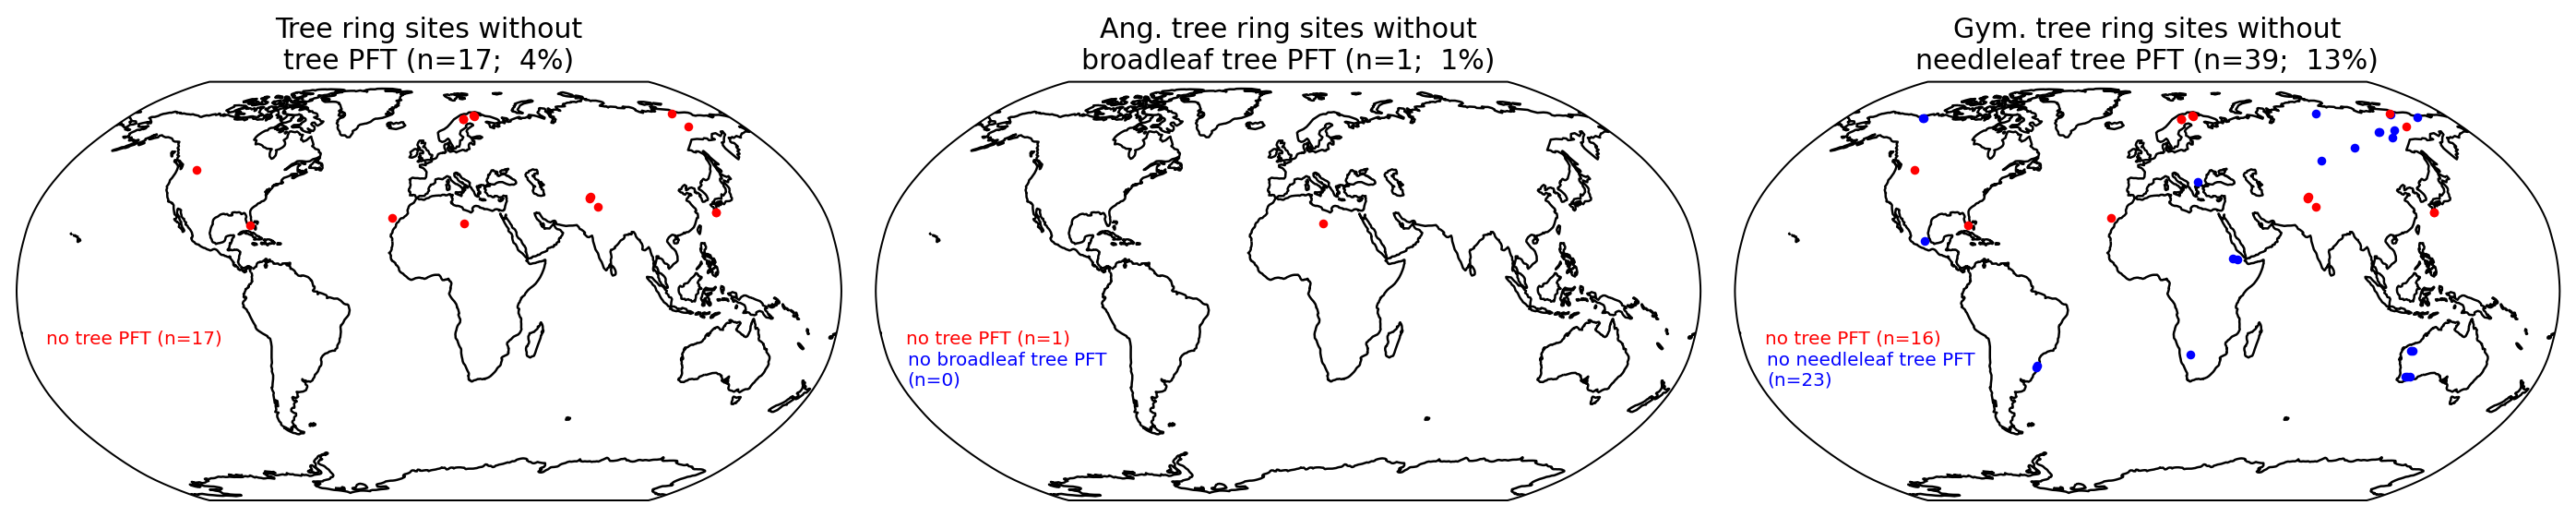

In [38]:
fig, axes = plt.subplots(
    1, 3,
    figsize=(15.5,3),
    layout='constrained',
    subplot_kw={'projection': ccrs.Robinson()},
)
ax = axes.ravel()

for i in sites_missing_treepfts.values:
    ax[0].scatter(
        tree_ring_coords.iloc[i].lon, tree_ring_coords.iloc[i].lat,
        s=8, color='red',
        transform=ccrs.PlateCarree()
    )
ax[0].set_title(f'Tree ring sites without\ntree PFT (n={sites_missing_treepfts.size}; {sites_missing_treepfts.size/tree_ring_coords.iloc[:,0].size*100: 0.0f}%)')
ax[0].text(-170, -20, f'no tree PFT (n={sites_missing_treepfts.size})', color='red', fontsize=8, transform=ccrs.PlateCarree())

n = 0
for i in sites_missing_angtreepfts.values:
    color = 'blue'
    if i in sites_missing_treepfts.values:
        n += 1
        color = 'red'
    ax[1].scatter(
        tree_ring_coords.iloc[i].lon, tree_ring_coords.iloc[i].lat,
        s=8, color=color,
        transform=ccrs.PlateCarree()
    )
ax[1].set_title(f'Ang. tree ring sites without\nbroadleaf tree PFT (n={sites_missing_angtreepfts.size}; {sites_missing_angtreepfts.size/ang_coords.iloc[:,0].size*100: 0.0f}%)')
ax[1].text(-170, -20, f'no tree PFT (n={n})', color='red', fontsize=8, transform=ccrs.PlateCarree())
ax[1].text(-170, -23, f'no broadleaf tree PFT\n(n={sites_missing_angtreepfts.size-n})', color='blue', fontsize=8, va='top', transform=ccrs.PlateCarree())

n=0
for i in sites_missing_gymtreepfts.values:
    color = 'blue'
    if i in sites_missing_treepfts.values:
        n += 1
        color = 'red'
    ax[2].scatter(
        tree_ring_coords.iloc[i].lon, tree_ring_coords.iloc[i].lat,
        s=8, color=color,
        transform=ccrs.PlateCarree()
    )
ax[2].set_title(f'Gym. tree ring sites without\nneedleleaf tree PFT (n={sites_missing_gymtreepfts.size}; {sites_missing_gymtreepfts.size/gym_coords.iloc[:,0].size*100: 0.0f}%)')
ax[2].text(-170, -20, f'no tree PFT (n={n})', color='red', fontsize=8, transform=ccrs.PlateCarree())
ax[2].text(-170, -23, f'no needleleaf tree PFT\n(n={sites_missing_gymtreepfts.size-n})', color='blue', fontsize=8, va='top', transform=ccrs.PlateCarree())

for a in ax:
    a.set_extent((-180, 180, -90, 90))
    a.coastlines(zorder=0)

# Get 2xCO2 runs

In [7]:
# 1xCO2 case
med_case_def_1x = ['coupled_DEFmedslope_1xCO2_03', 'coupled_DEFmedslope_1xCO2_05']
med_case_low_1x = ['coupled_LOWmedslope_1xCO2_03', 'coupled_LOWmedslope_1xCO2_05']
med_case_high_1x = ['coupled_HIGHmedslope_1xCO2_03', 'coupled_HIGHmedslope_1xCO2_05']

# 2xCO2 case
med_case_def_2x = ['coupled_DEFmedslope_2xCO2_03', 'coupled_DEFmedslope_2xCO2_05']
med_case_low_2x = ['coupled_LOWmedslope_2xCO2_04', 'coupled_LOWmedslope_2xCO2_06']
med_case_high_2x = ['coupled_HIGHmedslope_2xCO2_03', 'coupled_HIGHmedslope_2xCO2_05']

In [301]:
def open_files_with_overlap(glob_path, select_files=0):
    """
    Opens multiple files into a single dataset correcting
    for overlapping time coordinate dimensions
    """
    import glob
    
    # Get the files that match the glob path - sorting is crucial!
    matching_files = np.array(sorted(glob.glob(glob_path)))[select_files:]

    # Create empty array to hold the start/end year for each file
    file_times = np.empty((len(matching_files), 2), dtype=int)

    # Iterate through each file and save the start/end year
    for i, file in enumerate(matching_files):
        file_times[i,:] = [ int(x[:4]) for x in file.split('.')[-2].split('-') ]

    # Flatten and shift the array of years to check for overlap
    file_times_flat = file_times.flatten()
    overlap_times = file_times_flat[2::2] - file_times_flat[1:-1:2]
    overlap_files_index = np.where(overlap_times < 0)[0]

    # Return the time slice to eliminate the overlap
    if overlap_files_index.size > 0:
        print(f'{overlap_files_index.size} overlapping file(s)')
        correct_end_years = file_times[overlap_files_index][:,1] + overlap_times[overlap_files_index]# - 1  # Note: these runs start on Feb!!
        correct_end_times = [ f'{x:05.0f}-01'[1:] for x in correct_end_years ]  # Note: these runs start on Feb!!

        # Open each file and select the correct time periods to eliminate overlap
        these_ds = []
        overlap_index_counter = 0
        for i, file in enumerate(matching_files):
            ds = xr.open_dataset(file)
            if i in overlap_files_index:
                ds = ds.sel(time=slice(None, correct_end_times[overlap_index_counter]))
                overlap_index_counter += 1
            these_ds.append(ds)
        # Concatenate the individual datasets into one
        return xr.concat(these_ds, dim='time')

    # Open normally!
    return xc.open_mfdataset(glob_path)  

def check_time_concat(da):
    """
    Checks that the number of months in the DataArray is equal
    to the time dimension. Only works for monthly timeseries.
    """
    start_date = [ int(x) for x in da.time[ 0].item().strftime().split(' ')[0].split('-') ]
    end_date   = [ int(x) for x in da.time[-1].item().strftime().split(' ')[0].split('-') ]
    length_in_months = ( (end_date[0] - start_date[0]) * 12 ) + (end_date[1] - start_date[1]) + 1
    return da.time.size == length_in_months

def format_ds_coords(ds):
    """
    Formats a Dataset by centering the time coordinate to midpoints,
    adding bounds for the x-axis (lon) and y-axis (lat), and shifting
    the longitude coordinates to [-180,180].
    """
    ds = xc.center_times(ds)
    ds = ds.bounds.add_bounds('X')
    ds = ds.bounds.add_bounds('Y')
    ds = xc.swap_lon_axis(ds, (-180, 180))
    return ds

def open_stomatal_slope(var, case, dom='lnd', freq='month_1', htype='h0', is_coupled=True, remove_first_years=0, select_files=0):
    if is_coupled:
        maindir = '/glade/campaign/cgd/tss/people/czarakas/StomatalSlope2021/coupled_experiments'
    if not is_coupled:
        maindir = '/glade/campaign/cgd/tss/people/czarakas/StomatalSlope2021/offline_experiments'    
    
    # Open file(s) with variable of interest
    
    ds = open_files_with_overlap(f'{maindir}/{case}_0*/{dom}/proc/tseries/{freq}/{case}_*.{htype}.{var}*.nc', select_files=select_files)
    ds = format_ds_coords(ds)
    
    # Select the variable of interest
    da = ds[var]
    assert check_time_concat(da)

    # Select the equilibrium period
    da = da.isel(time=slice(remove_first_years*12, None))

    return da

def get_stomatal_slope_dict(var):
    medslope = { 'DEF':{}, 'LOW':{}, 'HIGH':{} }
    for slope, slope_dict in medslope.items():
        print(slope)

        print(' -> 1xCO2')
        select_files = 0
        if slope == 'HIGH':
            select_files = 1

        slope_dict['1xCO2'] = open_stomatal_slope(
            var, f'coupled_{slope}medslope_1xCO2',
            select_files=select_files,
            remove_first_years=40)
        
        
        print(' -> 2xCO2')
        slope_dict['2xCO2'] = open_stomatal_slope(
            var, f'coupled_{slope}medslope_2xCO2',
            remove_first_years=40)
    
    return medslope

# Plotting trends

In [31]:
def format_data_for_boxplot(linregress_data, conv_factor=1, get_significance=True, significance_threshold=0.01):
    import scipy.stats as stats

    alltrees = linregress_data.sel(vegtype=slice(0, 8), stats=0).mean(dim='vegtype', skipna=True).values * conv_factor
    alltrees = alltrees[~np.isnan(alltrees)]

    needletrees = linregress_data.sel(vegtype=slice(0, 3), stats=0).mean(dim='vegtype', skipna=True).values * conv_factor
    needletrees = needletrees[~np.isnan(needletrees)]

    broadtrees = linregress_data.sel(vegtype=slice(4, 8), stats=0).mean(dim='vegtype', skipna=True).values * conv_factor
    broadtrees = broadtrees[~np.isnan(broadtrees)]

    shrubs = linregress_data.sel(vegtype=slice(9, 11), stats=0).mean(dim='vegtype', skipna=True).values * conv_factor
    shrubs = shrubs[~np.isnan(shrubs)]

    grasses = linregress_data.sel(vegtype=slice(12, 14), stats=0).mean(dim='vegtype', skipna=True).values * conv_factor
    grasses = grasses[~np.isnan(grasses)]

    data = [alltrees.copy(), needletrees.copy(), broadtrees.copy(), shrubs.copy(), grasses.copy()]

    is_significant = []
    if get_significance:
        for this_data in data:
            ttest_result = stats.ttest_1samp(this_data, 0)
            is_significant.append([
                ttest_result.pvalue<significance_threshold,
                ttest_result.pvalue,
                ttest_result.statistic,
                ttest_result.df,
                ttest_result.confidence_interval(confidence_level=0.99)[0],
                ttest_result.confidence_interval(confidence_level=0.99)[1],
            ])

    return data, np.array(is_significant)

## Stomatal conductance

In [13]:
umol_to_mmol = 1/1000

# Full timeseries
full_ts_data, full_ts_significance = format_data_for_boxplot(gssunln_full_linregress, conv_factor=umol_to_mmol)
# Early subset timeseries
early_ts_data, early_ts_significance = format_data_for_boxplot(gssunln_early_linregress, conv_factor=umol_to_mmol)
# Late subset timeseries
late_ts_data, late_ts_significance = format_data_for_boxplot(gssunln_late_linregress, conv_factor=umol_to_mmol)

In [17]:
full_ts_significance[:,0]

array([1., 1., 1., 1., 1.])

In [18]:
early_ts_significance[:,0]

array([1., 1., 1., 1., 1.])

In [19]:
late_ts_significance[:,0]

array([1., 1., 1., 1., 1.])

Text(0.5, 1.0, '1965-2014 Trend')

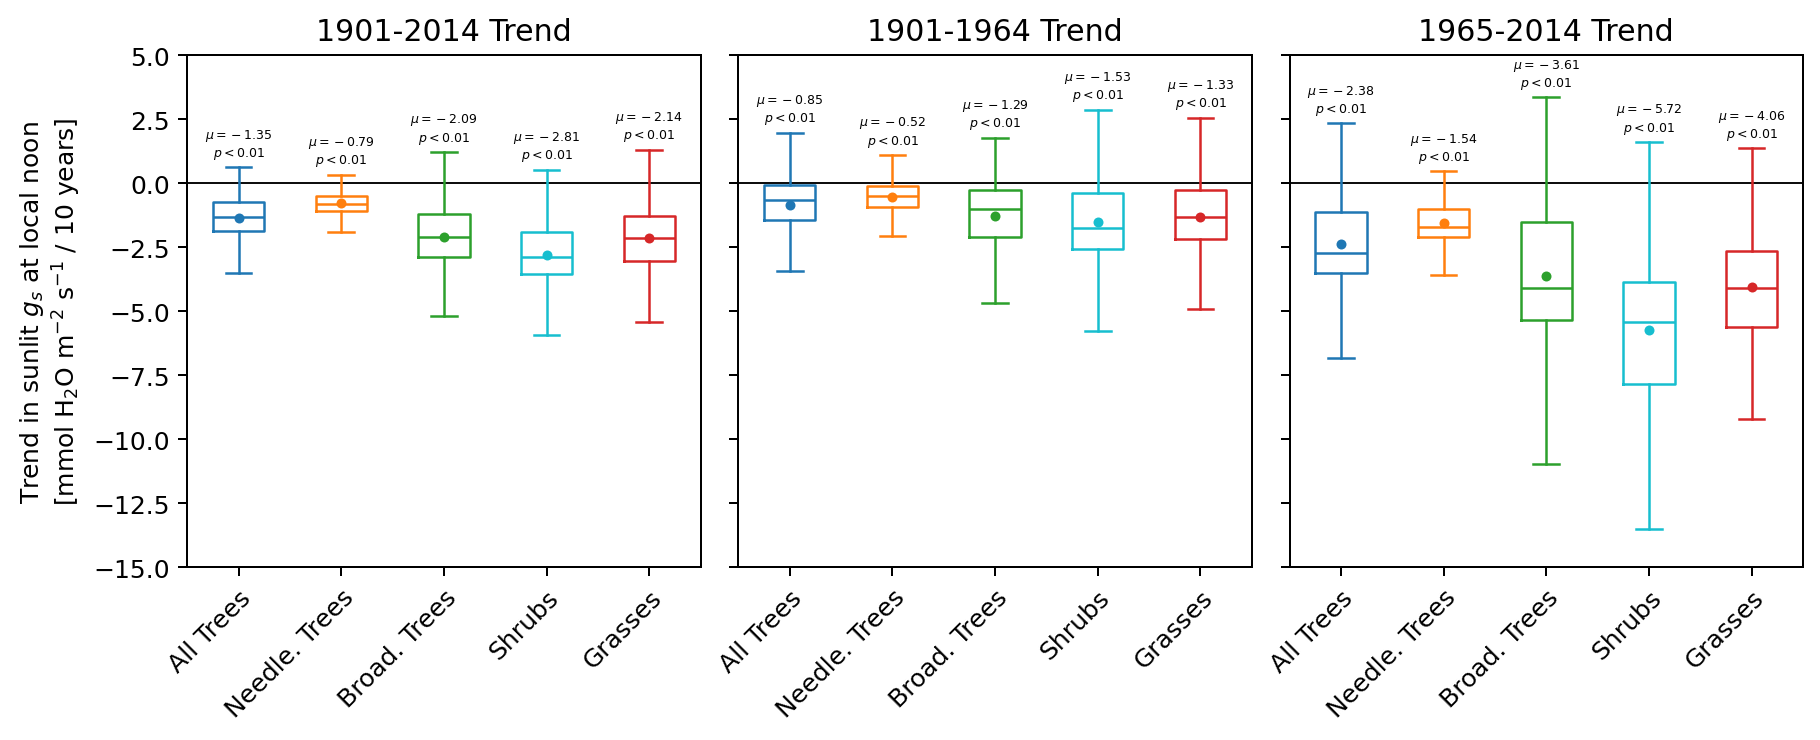

In [125]:
umol_to_mmol = 1/1000
# Full timeseries
full_ts_data, full_ts_significance = format_data_for_boxplot(gssunln_full_linregress, conv_factor=umol_to_mmol)
# Early subset timeseries
early_ts_data, early_ts_significance = format_data_for_boxplot(gssunln_early_linregress, conv_factor=umol_to_mmol)
# Late subset timeseries
late_ts_data, late_ts_significance = format_data_for_boxplot(gssunln_late_linregress, conv_factor=umol_to_mmol)

fig, axes = plt.subplots(
    1, 3,
    figsize=(10, 4),
    sharey=True,
    layout='constrained'
)
ax = axes.ravel()

color = ['tab:blue', 'tab:orange', 'tab:green', 'tab:cyan', 'tab:red']
positions = np.arange(len(full_ts_data))
bp = np.empty((3), dtype=dict)

for a in ax:
    a.axhline(0, -1, 6, c='k', lw=0.75)

for i, (this_data, this_signif) in enumerate(zip([full_ts_data, early_ts_data, late_ts_data], [full_ts_significance, early_ts_significance, late_ts_significance])):
    bp[i] = ax[i].boxplot(
        this_data,
        positions=positions,
        showmeans=True,
        # notch=True,
        # conf_intervals=this_signif[:,-2:],
        showfliers=False,
    )

for j, this_bp in enumerate(bp):
    for i,box in enumerate(this_bp['boxes']):
        box.set(linewidth=1, color=color[i])

    for i,med in enumerate(this_bp['medians']):
        med.set(linewidth=1, color=color[i])
    
    for i,whsk in enumerate(this_bp['whiskers']):
        whsk.set(linewidth=1, color=color[i//2])

    for i, (whsk, mean) in enumerate(zip(this_bp['whiskers'][1::2], this_bp['means'])):
        mean.set(marker='o', markerfacecolor=color[i], markeredgewidth=0, markersize=4)
        ax[j].text(
            x=whsk.get_data()[0][0],
            y=whsk.get_data()[1][1]+0.25,
            s=f'$\mu={mean.get_data()[1][0]: 0.2f}$\n$p<0.01$',
            va='bottom', ha='center',
            fontsize=5
        )

    for i,cap in enumerate(this_bp['caps']):
        cap.set(linewidth=1, color=color[i//2])        
    
for a in ax:
    a.set_xticks(positions)
    a.set_xticklabels(
        ['All Trees', 'Needle. Trees', 'Broad. Trees', 'Shrubs', 'Grasses'],
        rotation=45, ha='right', rotation_mode='anchor')
    a.set_ylim(-15, 5)

ax[0].set_ylabel('Trend in sunlit $g_s$ at local noon\n[mmol H$_2$O m$^{-2}$ s$^{-1}$ / 10 years]')
ax[0].set_title('1901-2014 Trend')
ax[1].set_title('1901-1964 Trend')
ax[2].set_title('1965-2014 Trend')

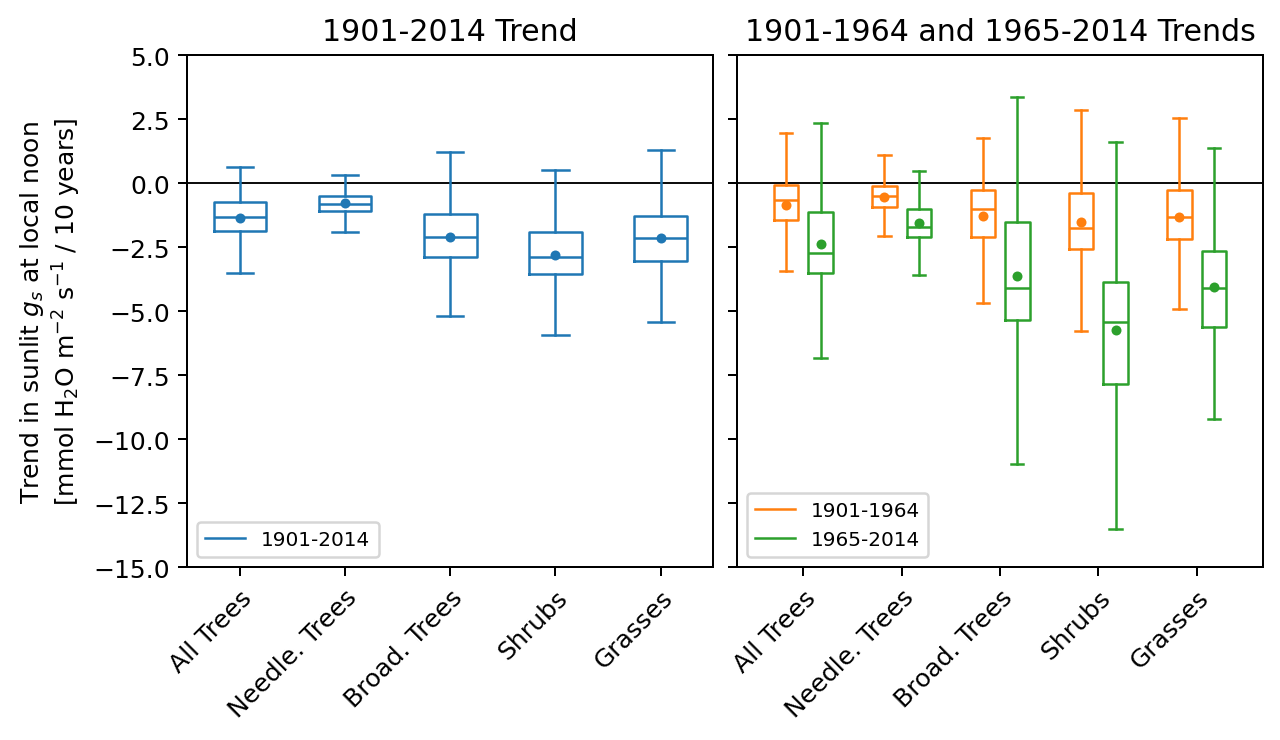

In [126]:
umol_to_mmol = 1/1000
# Full timeseries
full_ts_data, full_ts_significance = format_data_for_boxplot(gssunln_full_linregress, conv_factor=umol_to_mmol)
# Early subset timeseries
early_ts_data, early_ts_significance = format_data_for_boxplot(gssunln_early_linregress, conv_factor=umol_to_mmol)
# Late subset timeseries
late_ts_data, late_ts_significance = format_data_for_boxplot(gssunln_late_linregress, conv_factor=umol_to_mmol)

fig, axes = plt.subplots(
    1, 2,
    figsize=(7, 4),
    sharey=True,
    layout='constrained'
)
ax = axes.ravel()

to_showfliers = False
color = ['tab:blue', 'tab:orange', 'tab:green']
positions = np.arange(len(full_ts_data))
pos_offset = 0.175
width = 0.25
bp = np.empty((3), dtype=dict)

for a in ax:
    a.axhline(0, -1, 6, c='k', lw=0.75)

bp[0] = ax[0].boxplot(
    full_ts_data,
    positions=positions,
    showmeans=True,
    showfliers=to_showfliers
)

bp[1] = ax[1].boxplot(
    early_ts_data,
    positions=positions-pos_offset,
    widths=width,
    showmeans=True,
    showfliers=to_showfliers
)

bp[2] = ax[1].boxplot(
    late_ts_data,
    positions=positions+pos_offset,
    widths=width,
    showmeans=True,
    showfliers=to_showfliers
)

for j, this_bp in enumerate(bp):
    for i,box in enumerate(this_bp['boxes']):
        box.set(linewidth=1, color=color[j])

    for i,med in enumerate(this_bp['medians']):
        med.set(linewidth=1, color=color[j])
    
    for i,whsk in enumerate(this_bp['whiskers']):
        if j == 0: c = color[j]
        else: c = color[j//2+1]
        whsk.set(linewidth=1, color=c)

    for i, (whsk, mean) in enumerate(zip(this_bp['whiskers'][1::2], this_bp['means'])):
        mean.set(marker='o', markerfacecolor=color[j], markeredgewidth=0, markersize=4)

    for i,cap in enumerate(this_bp['caps']):
        if j == 0: c = color[j]
        else: c = color[j//2+1]
        cap.set(linewidth=1, color=c)
    
    if to_showfliers:
        for i,flier in enumerate(this_bp['fliers']):
            flier.set(marker='+', markeredgecolor=color[j], markersize=3)
    
for a in ax:
    a.set_xticks(positions)
    a.set_xticklabels(
        ['All Trees', 'Needle. Trees', 'Broad. Trees', 'Shrubs', 'Grasses'],
        rotation=45, ha='right', rotation_mode='anchor')
    a.set_ylim(-15, 5)
    if to_showfliers:
        a.set_ylim(-25, 30)

ax[0].set_ylabel('Trend in sunlit $g_s$ at local noon\n[mmol H$_2$O m$^{-2}$ s$^{-1}$ / 10 years]')
ax[0].set_title('1901-2014 Trend')
ax[1].set_title('1901-1964 and 1965-2014 Trends')

ax[0].legend([bp[0]['boxes'][0]], ['1901-2014'], loc='lower left', fontsize=8)
ax[1].legend([bp[1]['boxes'][0], bp[2]['boxes'][0]], ['1901-1964', '1965-2014'], loc='lower left', fontsize=8)

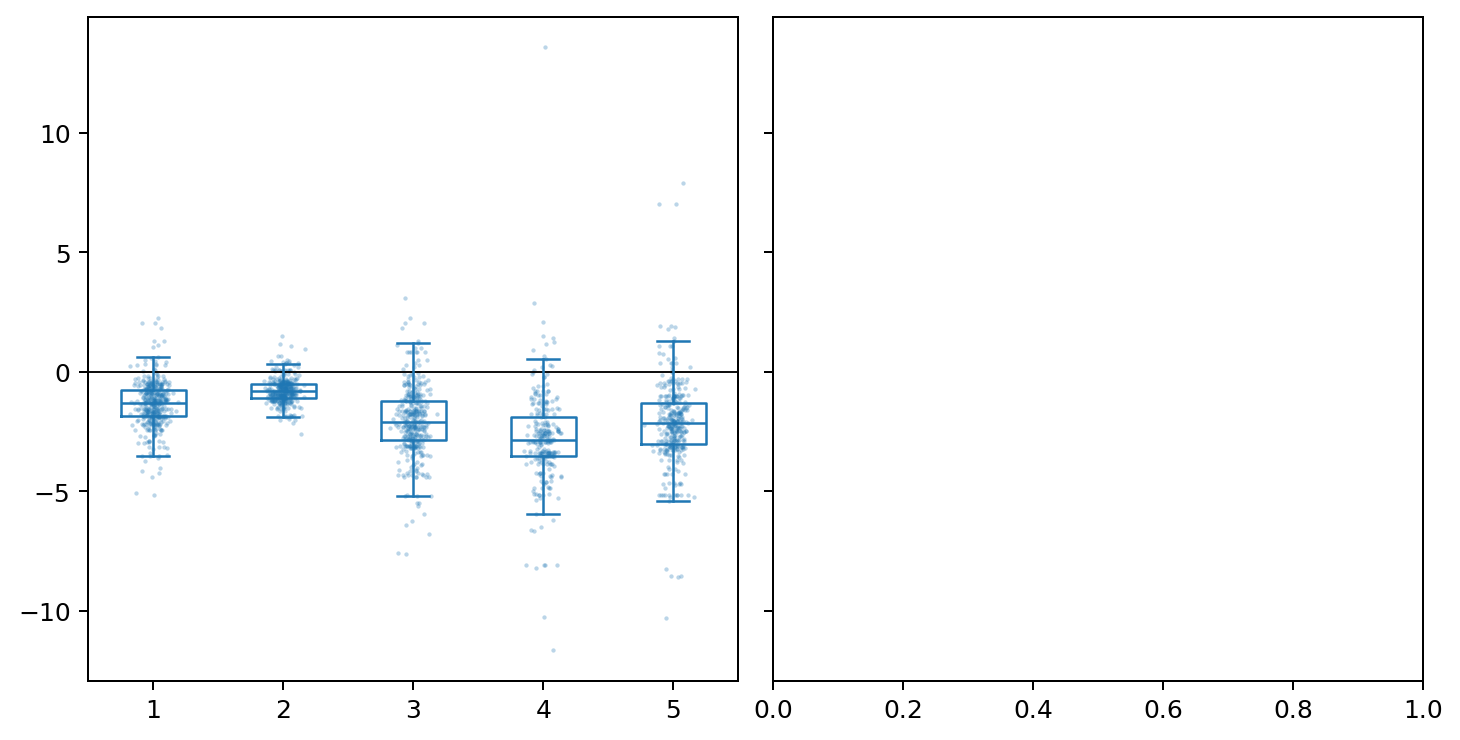

In [77]:
fig, axes = plt.subplots(
    1, 3,
    figsize=(10, 4),
    sharey=True,
    layout='constrained'
)
ax = axes.ravel()

color = ['tab:blue', 'tab:orange', 'tab:green', 'tab:cyan', 'tab:red']
positions = np.arange(len(full_ts_data))
bp = np.empty((3), dtype=dict)

for a in ax:
    a.axhline(0, -1, 6, c='k', lw=0.75)
    a.axhline(0, -1, 6, c='k', lw=0.75)
    a.axhline(0, -1, 6, c='k', lw=0.75)

for i, y in enumerate(full_ts_data):
    x = np.random.normal(i+1, 0.06, size=len(y))
    ax[0].scatter(
        x, y,
        s=12, marker='.',
        facecolor=color[i],
        linewidth=0,
        alpha=0.3
    )

for i, (this_data, this_signif, xpos) in enumerate(zip([full_ts_data, early_ts_data, late_ts_data], [full_ts_significance, early_ts_significance, late_ts_significance], [0, -0.5, 0.5])):
    if xpos == 0:
    bp[i] = ax[i].boxplot(
        this_data,
        positions=positions+xpos,
        notch=True,
        # conf_intervals=this_signif[:,-2:],
        showfliers=False
    )

for this_bp in bp:
    for i,box in enumerate(this_bp['boxes']):
        box.set(linewidth=1, color=color[i])

    for i,med in enumerate(this_bp['medians']):
        med.set(linewidth=1, color=color[i])

    for i,whsk in enumerate(this_bp['whiskers']):
        whsk.set(linewidth=1, color=color[i//2])

    for i,cap in enumerate(this_bp['caps']):
        cap.set(linewidth=1, color=color[i//2])
    
for a in ax:
    a.set_xticks(positions)
    a.set_xticklabels(['All Trees', 'Needle. Trees', 'Broad. Trees', 'Shrubs', 'Grasses'], rotation=45, ha='right', rotation_mode='anchor')

ax[0].set_ylabel('Trend in sunlit $g_s$ at local noon\n[mmol m$^{-2}$ s$^{-1}$ / 10 years]')
ax[0].set_title('1901-2014 Trend')
ax[1].set_title('1901-1964 Trend')
ax[2].set_title('1965-2014 Trend')

Text(0.5, 1.0, 'Pre- and post-1965')

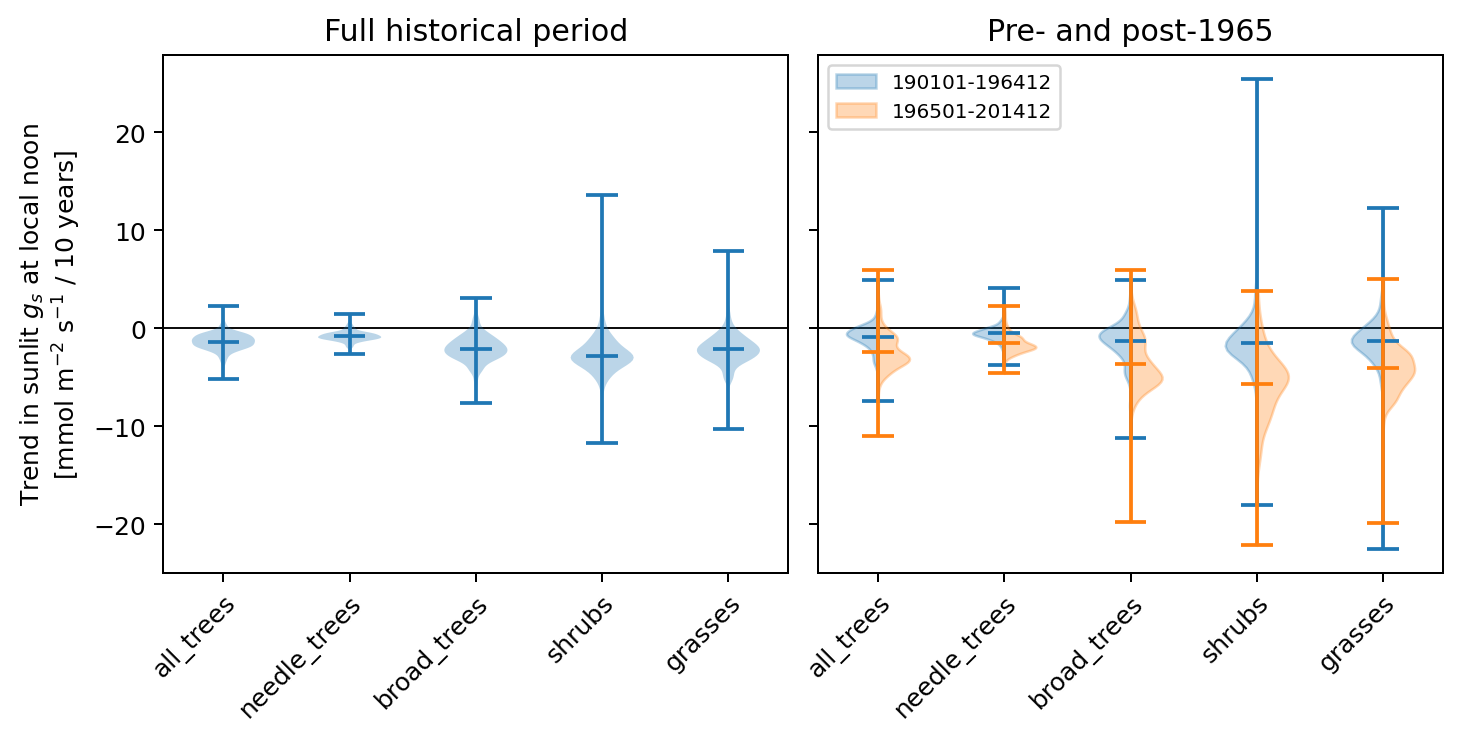

In [106]:
umol_to_mmol = 1/1000

# Full timeseries
full_ts_data, full_ts_significance = format_data_for_boxplot(gssunln_full_linregress, conv_factor=umol_to_mmol)

# Early subset timeseries
early_ts_data, early_ts_significance = format_data_for_boxplot(gssunln_early_linregress, conv_factor=umol_to_mmol)

# Late subset timeseries
late_ts_data, late_ts_significance = format_data_for_boxplot(gssunln_late_linregress, conv_factor=umol_to_mmol)

fig, axes = plt.subplots(
    1, 2,
    figsize=(8, 4),
    sharey=True,
    layout='constrained'
)
ax = axes.ravel()

positions = np.arange(len(full_ts_data))

ax[0].violinplot(full_ts_data, positions=positions, showmeans=True)
ax[0].set_ylabel('Trend in sunlit $g_s$ at local noon\n[mmol m$^{-2}$ s$^{-1}$ / 10 years]')

v1 = ax[1].violinplot(early_ts_data, positions=positions, showmeans=True)
for b in v1['bodies']:
    # get the center
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    # modify the paths to not go further right than the center
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], -np.inf, m)
    b.set_color('tab:blue')

v2 = ax[1].violinplot(late_ts_data, positions=positions, showmeans=True)
for b in v2['bodies']:
    # get the center
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    # modify the paths to not go further left than the center
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
    b.set_color('tab:orange')

ax[1].legend([v1['bodies'][0],v2['bodies'][0]],['190101-196412', '196501-201412'], loc='upper left', fontsize=8)

for a in ax:
    a.axhline(0, -1, 5, lw=0.75, c='k', zorder=0)
    a.set_xticks(positions)
    a.set_xticklabels(['all_trees', 'needle_trees', 'broad_trees', 'shrubs', 'grasses'], rotation=45, ha='right', rotation_mode='anchor')

ax[0].set_title('Full historical period')
ax[1].set_title('Pre- and post-1965')

## GPP

Text(0.5, 1.0, '1965-2014 Trend')

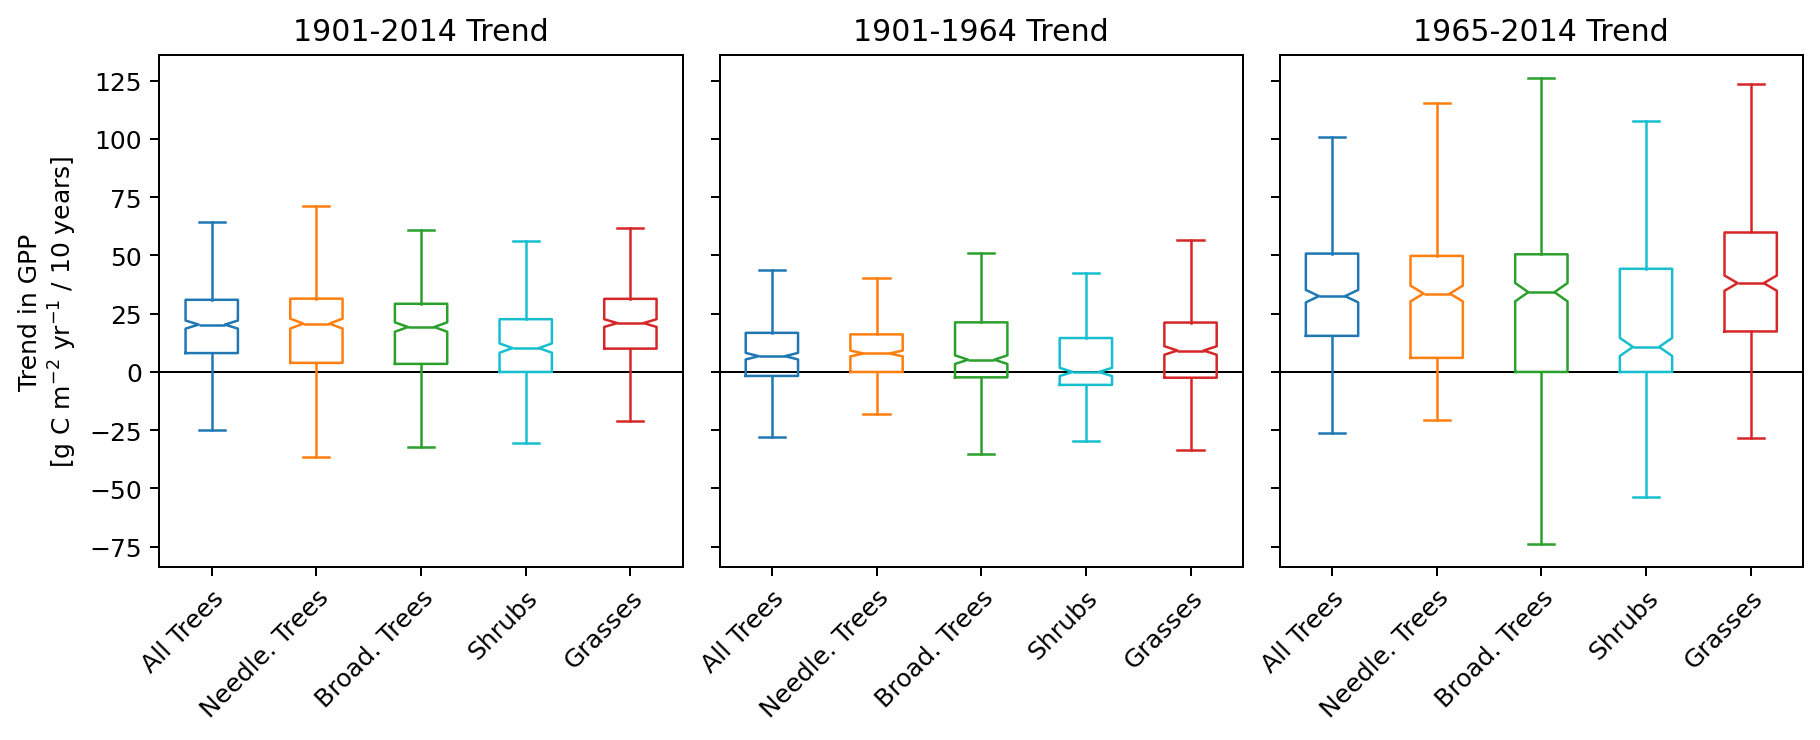

In [127]:
s_to_year = 60 * 60 * 24 * 365
# Full timeseries
full_ts_data, full_ts_significance = format_data_for_boxplot(gpp_full_linregress, conv_factor=s_to_year)
# Early subset timeseries
early_ts_data, early_ts_significance = format_data_for_boxplot(gpp_early_linregress, conv_factor=s_to_year)
# Late subset timeseries
late_ts_data, late_ts_significance = format_data_for_boxplot(gpp_late_linregress, conv_factor=s_to_year)

fig, axes = plt.subplots(
    1, 3,
    figsize=(10, 4),
    sharey=True,
    layout='constrained'
)
ax = axes.ravel()

color = ['tab:blue', 'tab:orange', 'tab:green', 'tab:cyan', 'tab:red']
positions = np.arange(len(full_ts_data))
bp = np.empty((3), dtype=dict)

for a in ax:
    a.axhline(0, -1, 6, c='k', lw=0.75)
    a.axhline(0, -1, 6, c='k', lw=0.75)
    a.axhline(0, -1, 6, c='k', lw=0.75)

for i, (this_data, this_signif) in enumerate(zip([full_ts_data, early_ts_data, late_ts_data], [full_ts_significance, early_ts_significance, late_ts_significance])):
    bp[i] = ax[i].boxplot(
        this_data,
        positions=positions,
        notch=True,
        # conf_intervals=this_signif[:,-2:],
        showfliers=False
    )

for this_bp in bp:
    for i,box in enumerate(this_bp['boxes']):
        box.set(linewidth=1, color=color[i])

    for i,med in enumerate(this_bp['medians']):
        med.set(linewidth=1, color=color[i])

    for i,whsk in enumerate(this_bp['whiskers']):
        whsk.set(linewidth=1, color=color[i//2])

    for i,cap in enumerate(this_bp['caps']):
        cap.set(linewidth=1, color=color[i//2])
    
for a in ax:
    a.set_xticks(positions)
    a.set_xticklabels(['All Trees', 'Needle. Trees', 'Broad. Trees', 'Shrubs', 'Grasses'], rotation=45, ha='right', rotation_mode='anchor')

ax[0].set_ylabel('Trend in GPP\n[g C m$^{-2}$ yr$^{-1}$ / 10 years]')
ax[0].set_title('1901-2014 Trend')
ax[1].set_title('1901-1964 Trend')
ax[2].set_title('1965-2014 Trend')

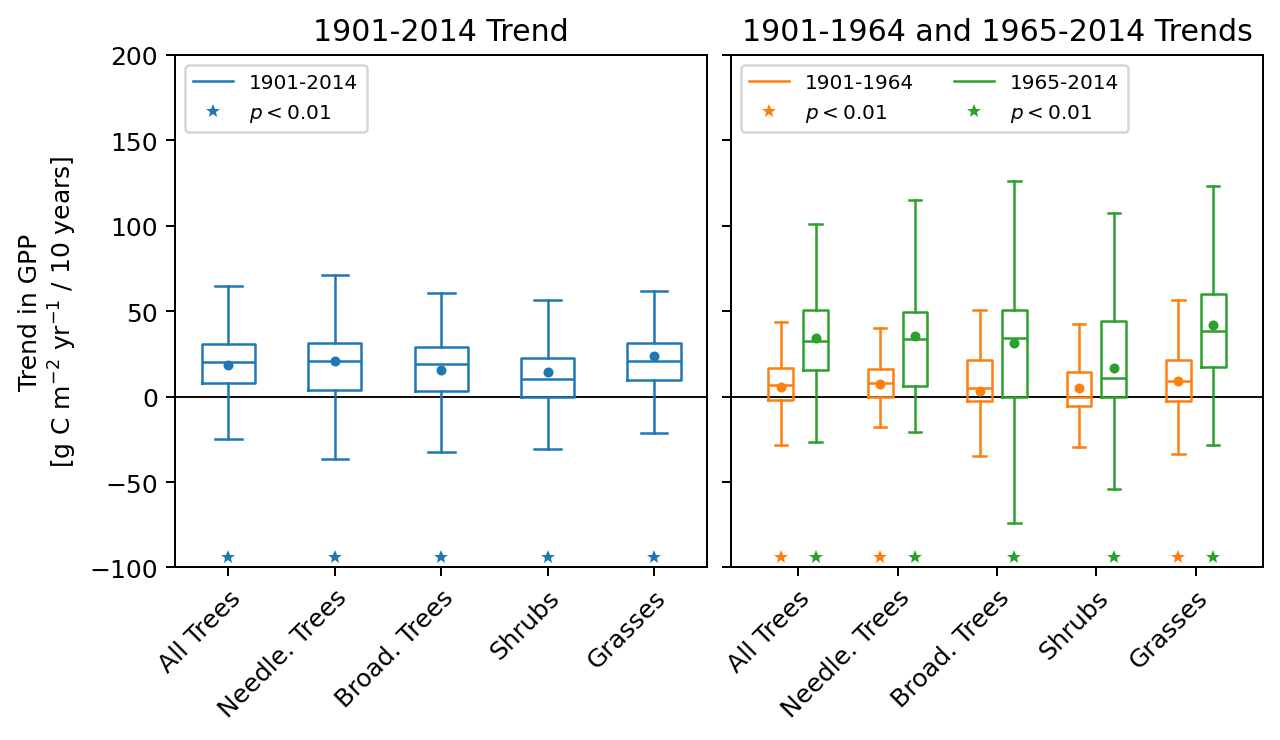

In [162]:
s_to_year = 60 * 60 * 24 * 365
# Full timeseries
full_ts_data, full_ts_significance = format_data_for_boxplot(gpp_full_linregress, conv_factor=s_to_year)
# Early subset timeseries
early_ts_data, early_ts_significance = format_data_for_boxplot(gpp_early_linregress, conv_factor=s_to_year)
# Late subset timeseries
late_ts_data, late_ts_significance = format_data_for_boxplot(gpp_late_linregress, conv_factor=s_to_year)

fig, axes = plt.subplots(
    1, 2,
    figsize=(7, 4),
    sharey=True,
    layout='constrained'
)
ax = axes.ravel()

to_showfliers = False
color = ['tab:blue', 'tab:orange', 'tab:green']
positions = np.arange(len(full_ts_data))
pos_offset = 0.175
width = 0.25
bp = np.empty((3), dtype=dict)

for a in ax:
    a.axhline(0, -1, 6, c='k', lw=0.75)

bp[0] = ax[0].boxplot(
    full_ts_data,
    positions=positions,
    showmeans=True,
    showfliers=to_showfliers
)

bp[1] = ax[1].boxplot(
    early_ts_data,
    positions=positions-pos_offset,
    widths=width,
    showmeans=True,
    showfliers=to_showfliers
)

bp[2] = ax[1].boxplot(
    late_ts_data,
    positions=positions+pos_offset,
    widths=width,
    showmeans=True,
    showfliers=to_showfliers
)

for j, this_bp in enumerate(bp):
    for i,box in enumerate(this_bp['boxes']):
        box.set(linewidth=1, color=color[j])

    for i,med in enumerate(this_bp['medians']):
        med.set(linewidth=1, color=color[j])
    
    for i,whsk in enumerate(this_bp['whiskers']):
        if j == 0: c = color[j]
        else: c = color[j//2+1]
        whsk.set(linewidth=1, color=c)

    for i, (whsk, mean) in enumerate(zip(this_bp['whiskers'][1::2], this_bp['means'])):
        mean.set(marker='o', markerfacecolor=color[j], markeredgewidth=0, markersize=4)

    for i,cap in enumerate(this_bp['caps']):
        if j == 0: c = color[j]
        else: c = color[j//2+1]
        cap.set(linewidth=1, color=c)
    
    if to_showfliers:
        for i,flier in enumerate(this_bp['fliers']):
            flier.set(marker='+', markeredgecolor=color[j], markersize=3)
    
for a in ax:
    a.set_xticks(positions)
    a.set_xticklabels(
        ['All Trees', 'Needle. Trees', 'Broad. Trees', 'Shrubs', 'Grasses'],
        rotation=45, ha='right', rotation_mode='anchor')
    a.set_ylim(-100, 200)
    if to_showfliers:
        a.set_ylim(-450, 500)

# Plot an asterisk on the x-axis if the mean of the distribution is statistically
# different than zero (p<0.01 from a single-sample t-test)
for i, signif in enumerate(full_ts_significance):
    if signif[0] == 1:
        star_full = ax[0].plot(
            positions[i],
            ax[0].get_ylim()[0]+(ax[0].get_ylim()[1]-ax[0].get_ylim()[0])*0.02,
            '*',
            markerfacecolor=color[0],
            markeredgewidth=0,
        )

for i, signif in enumerate(early_ts_significance):
    if signif[0] == 1:
        star_early = ax[1].plot(
            positions[i]-pos_offset,
            ax[0].get_ylim()[0]+(ax[0].get_ylim()[1]-ax[0].get_ylim()[0])*0.02,
            '*',
            markerfacecolor=color[1],
            markeredgewidth=0,
        )

for i, signif in enumerate(late_ts_significance):
    if signif[0] == 1:
        star_late = ax[1].plot(
            positions[i]+pos_offset,
            ax[0].get_ylim()[0]+(ax[0].get_ylim()[1]-ax[0].get_ylim()[0])*0.02,
            '*',
            markerfacecolor=color[2],
            markeredgewidth=0,
        )

ax[0].set_ylabel('Trend in GPP\n[g C m$^{-2}$ yr$^{-1}$ / 10 years]')
ax[0].set_title('1901-2014 Trend')
ax[1].set_title('1901-1964 and 1965-2014 Trends')

ax[0].legend(
    [bp[0]['boxes'][0], star[0]],
    ['1901-2014', '$p<0.01$'],
    ncol=1, loc='upper left',
    fontsize=8
)
ax[1].legend(
    [bp[1]['boxes'][0], star_early[0], bp[2]['boxes'][0], star_late[0]],
    ['1901-1964', '$p<0.01$', '1965-2014', '$p<0.01$'],
    ncol=2, loc='upper left',
    fontsize=8
)

Text(0.5, 1.0, 'Pre- and post-1965')

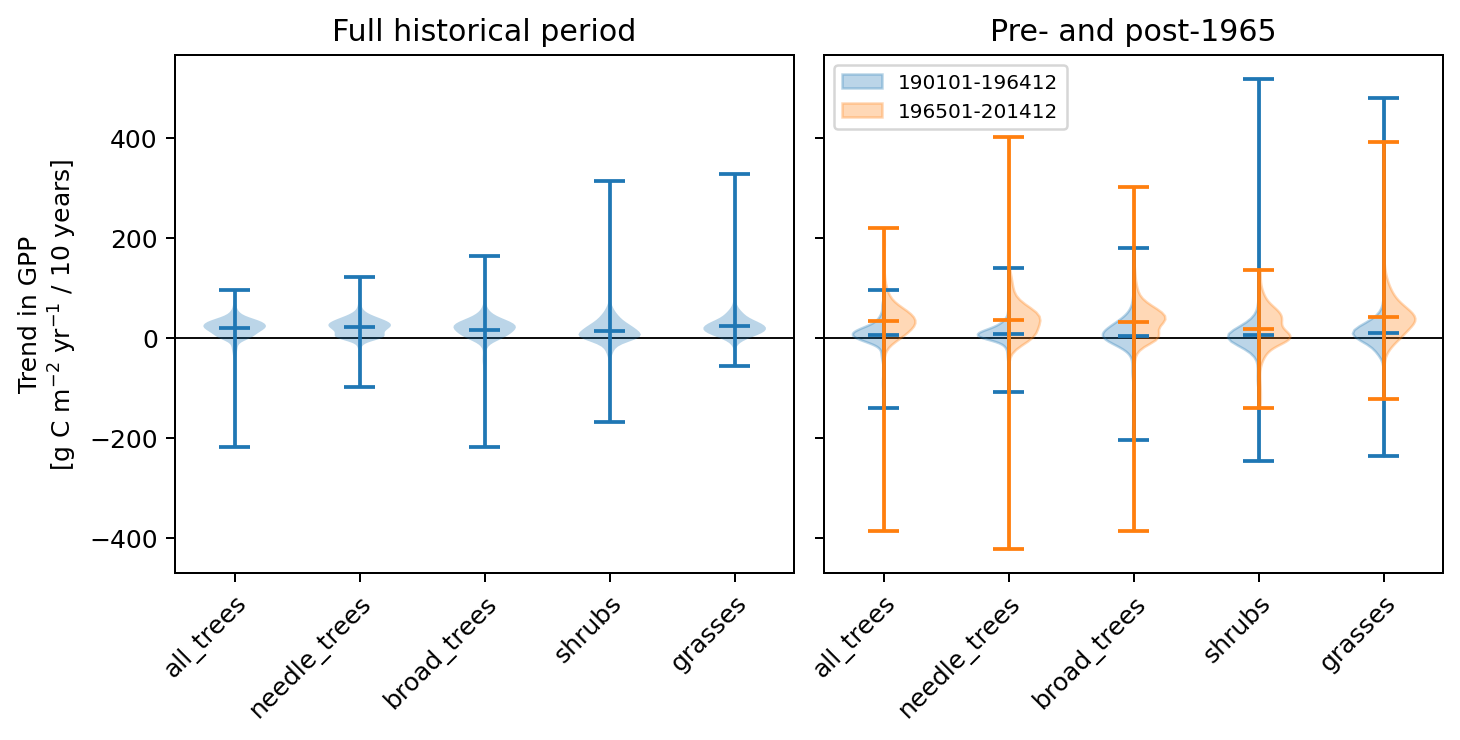

In [205]:
s_to_year = 60 * 60 * 24 * 365

# Full timeseries
full_ts_data = format_data_for_boxplot(gpp_full_linregress, conv_factor=s_to_year)

# Early subset timeseries
early_ts_data = format_data_for_boxplot(gpp_early_linregress, conv_factor=s_to_year)

# Late subset timeseries
late_ts_data = format_data_for_boxplot(gpp_late_linregress, conv_factor=s_to_year)

fig, axes = plt.subplots(
    1, 2,
    figsize=(8, 4),
    sharey=True,
    layout='constrained'
)
ax = axes.ravel()

positions = np.arange(len(full_ts_data))

ax[0].violinplot(full_ts_data, positions=positions, showmeans=True)
ax[0].set_ylabel('Trend in GPP\n[g C m$^{-2}$ yr$^{-1}$ / 10 years]')

v1 = ax[1].violinplot(early_ts_data, positions=positions, showmeans=True)
for b in v1['bodies']:
    # get the center
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    # modify the paths to not go further right than the center
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], -np.inf, m)
    b.set_color('tab:blue')

v2 = ax[1].violinplot(late_ts_data, positions=positions, showmeans=True)
for b in v2['bodies']:
    # get the center
    m = np.mean(b.get_paths()[0].vertices[:, 0])
    # modify the paths to not go further left than the center
    b.get_paths()[0].vertices[:, 0] = np.clip(b.get_paths()[0].vertices[:, 0], m, np.inf)
    b.set_color('tab:orange')

ax[1].legend([v1['bodies'][0],v2['bodies'][0]],['190101-196412', '196501-201412'], loc='upper left', fontsize=8)

for a in ax:
    a.axhline(0, -1, 5, lw=0.75, c='k', zorder=0)
    a.set_xticks(positions)
    a.set_xticklabels(['all_trees', 'needle_trees', 'broad_trees', 'shrubs', 'grasses'], rotation=45, ha='right', rotation_mode='anchor')

ax[0].set_title('Full historical period')
ax[1].set_title('Pre- and post-1965')

# Stomatal conductance and GPP

In [152]:
def create_boxplot(ax, data, significance, ylabel, ylim_nofliers, ylim_withfliers):
    assert len(ax) == 2
    assert len(data) == 3

    to_showfliers = False
    color = ['tab:blue', 'tab:orange', 'tab:green']
    positions = np.arange(len(data[0]))
    pos_offset = 0.175
    width = 0.25
    bp = np.empty((3), dtype=dict)

    for a in ax:
        a.axhline(0, -1, 6, c='k', lw=0.75)

    bp[0] = ax[0].boxplot(
        data[0],
        positions=positions,
        showmeans=True,
        showfliers=to_showfliers
    )

    bp[1] = ax[1].boxplot(
        data[1],
        positions=positions-pos_offset,
        widths=width,
        showmeans=True,
        showfliers=to_showfliers
    )

    bp[2] = ax[1].boxplot(
        data[2],
        positions=positions+pos_offset,
        widths=width,
        showmeans=True,
        showfliers=to_showfliers
    )

    for j, this_bp in enumerate(bp):
        for i,box in enumerate(this_bp['boxes']):
            box.set(linewidth=1, color=color[j])

        for i,med in enumerate(this_bp['medians']):
            med.set(linewidth=1, color=color[j])
        
        for i,whsk in enumerate(this_bp['whiskers']):
            if j == 0: c = color[j]
            else: c = color[j//2+1]
            whsk.set(linewidth=1, color=c)

        for i, (whsk, mean) in enumerate(zip(this_bp['whiskers'][1::2], this_bp['means'])):
            mean.set(marker='o', markerfacecolor=color[j], markeredgewidth=0, markersize=4)

        for i,cap in enumerate(this_bp['caps']):
            if j == 0: c = color[j]
            else: c = color[j//2+1]
            cap.set(linewidth=1, color=c)
        
        if to_showfliers:
            for i,flier in enumerate(this_bp['fliers']):
                flier.set(marker='+', markeredgecolor=color[j], markersize=3)
        
    for a in ax:
        a.set_xticks(positions)
        a.set_xticklabels(
            ['All Trees', 'Needle. Trees', 'Broad. Trees', 'Shrubs', 'Grasses'],
            rotation=45, ha='right', rotation_mode='anchor')
        a.set_ylim(ylim_nofliers[0], ylim_nofliers[1])
        if to_showfliers:
            a.set_ylim(ylim_withfliers[0], ylim_withfliers[1])

    # Plot an asterisk on the x-axis if the mean of the distribution is statistically
    # different than zero (p<0.01 from a single-sample t-test)
    for i, signif in enumerate(significance[0]):
        if signif[0] == 1:
            star_full = ax[0].plot(
                positions[i],
                ax[0].get_ylim()[0]+(ax[0].get_ylim()[1]-ax[0].get_ylim()[0])*0.02,
                '*',
                markerfacecolor=color[0],
                markeredgewidth=0,
            )

    for i, signif in enumerate(significance[1]):
        if signif[0] == 1:
            star_early = ax[1].plot(
                positions[i]-pos_offset,
                ax[0].get_ylim()[0]+(ax[0].get_ylim()[1]-ax[0].get_ylim()[0])*0.02,
                '*',
                markerfacecolor=color[1],
                markeredgewidth=0,
            )

    for i, signif in enumerate(significance[2]):
        if signif[0] == 1:
            star_late = ax[1].plot(
                positions[i]+pos_offset,
                ax[0].get_ylim()[0]+(ax[0].get_ylim()[1]-ax[0].get_ylim()[0])*0.02,
                '*',
                markerfacecolor=color[2],
                markeredgewidth=0,
            )

    ax[0].set_ylabel(ylabel)
    ax[1].yaxis.set_ticklabels([])

    ax[0].legend(
        [bp[0]['boxes'][0], star_full[0]],
        ['1901-2014', '$p<0.01$'],
        ncol=1, loc='upper left',
        fontsize=8
    )
    ax[1].legend(
        [bp[1]['boxes'][0], star_early[0], bp[2]['boxes'][0], star_late[0]],
        ['1901-1964', '$p<0.01$', '1965-2014', '$p<0.01$'],
        ncol=2, loc='upper left',
        fontsize=8
    )

    return ax

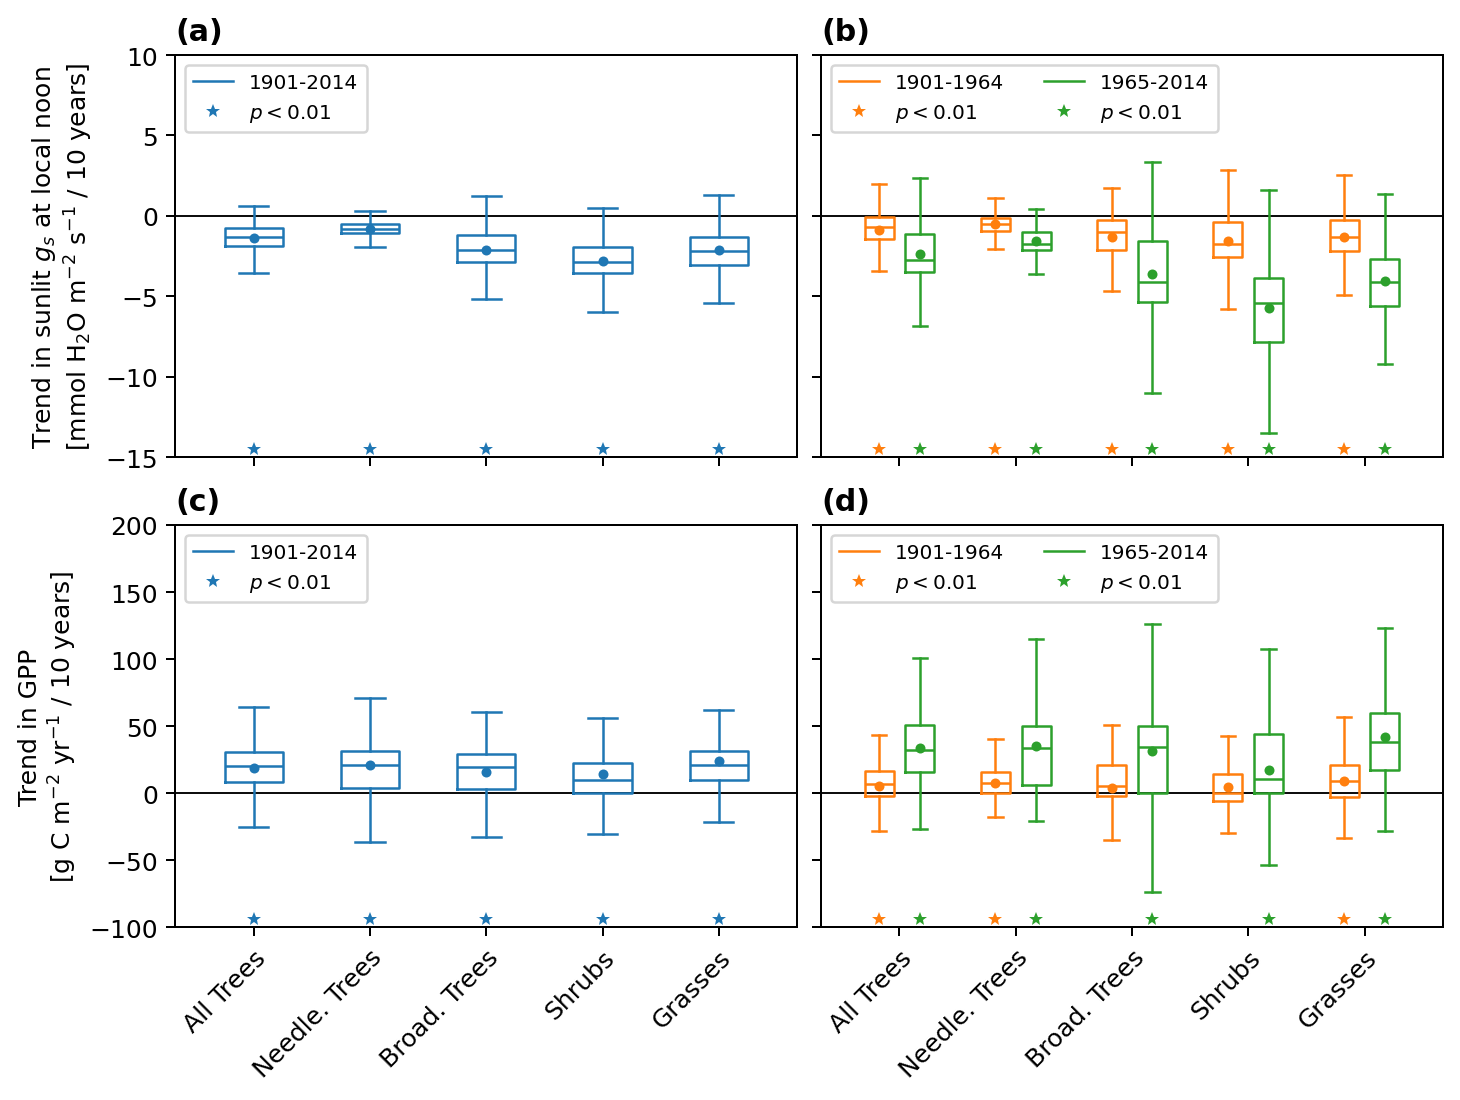

In [79]:
fig, axes = plt.subplots(
    2, 2,
    figsize=(8, 6),
    sharey=False,
    sharex=True,
    layout='constrained'
)
ax = axes.ravel()

umol_to_mmol = 1/1000
# Full timeseries
full_ts_data, full_ts_significance = format_data_for_boxplot(gssunln_full_linregress, conv_factor=umol_to_mmol)
# Early subset timeseries
early_ts_data, early_ts_significance = format_data_for_boxplot(gssunln_early_linregress, conv_factor=umol_to_mmol)
# Late subset timeseries
late_ts_data, late_ts_significance = format_data_for_boxplot(gssunln_late_linregress, conv_factor=umol_to_mmol)

ax[:2] = create_boxplot(
    ax=ax[:2],
    data=[full_ts_data, early_ts_data, late_ts_data],
    significance=[full_ts_significance, early_ts_significance, late_ts_significance],
    ylabel='Trend in sunlit $g_s$ at local noon\n[mmol H$_2$O m$^{-2}$ s$^{-1}$ / 10 years]',
    ylim_nofliers=[-15, 10],
    ylim_withfliers=[-25, 30],
)

s_to_year = 60 * 60 * 24 * 365
# Full timeseries
full_ts_data, full_ts_significance = format_data_for_boxplot(gpp_full_linregress, conv_factor=s_to_year)
# Early subset timeseries
early_ts_data, early_ts_significance = format_data_for_boxplot(gpp_early_linregress, conv_factor=s_to_year)
# Late subset timeseries
late_ts_data, late_ts_significance = format_data_for_boxplot(gpp_late_linregress, conv_factor=s_to_year)

ax[2:] = create_boxplot(
    ax=ax[2:],
    data=[full_ts_data, early_ts_data, late_ts_data],
    significance=[full_ts_significance, early_ts_significance, late_ts_significance],
    ylabel='Trend in GPP\n[g C m$^{-2}$ yr$^{-1}$ / 10 years]',
    ylim_nofliers=[-100, 200],
    ylim_withfliers=[-450, 500],
)

# ax[0].set_title('1901-2014 Trend')
# ax[1].set_title('1901-1964 and 1965-2014 Trends')

for a, label in zip(ax, ['(a)', '(b)', '(c)', '(d)']):
    a.set_title(label, fontweight='bold', loc='left')

In [ ]:
fig, axes = plt.subplots(
    3, 2,
    figsize=(8, 9),
    sharey=False,
    sharex=True,
    layout='constrained'
)
ax = axes.ravel()

umol_to_mmol = 1/1000
# Full timeseries
full_ts_data, full_ts_significance = format_data_for_boxplot(gssunln_full_linregress, conv_factor=umol_to_mmol)
# Early subset timeseries
early_ts_data, early_ts_significance = format_data_for_boxplot(gssunln_early_linregress, conv_factor=umol_to_mmol)
# Late subset timeseries
late_ts_data, late_ts_significance = format_data_for_boxplot(gssunln_late_linregress, conv_factor=umol_to_mmol)

ax[:2] = create_boxplot(
    ax=ax[:2],
    data=[full_ts_data, early_ts_data, late_ts_data],
    significance=[full_ts_significance, early_ts_significance, late_ts_significance],
    ylabel='Trend in sunlit $g_s$ at local noon\n[mmol H$_2$O m$^{-2}$ s$^{-1}$ / 10 years]',
    ylim_nofliers=[-15, 10],
    ylim_withfliers=[-25, 30],
)

s_to_year = 60 * 60 * 24 * 365
# Full timeseries
full_ts_data, full_ts_significance = format_data_for_boxplot(gpp_full_linregress, conv_factor=s_to_year)
# Early subset timeseries
early_ts_data, early_ts_significance = format_data_for_boxplot(gpp_early_linregress, conv_factor=s_to_year)
# Late subset timeseries
late_ts_data, late_ts_significance = format_data_for_boxplot(gpp_late_linregress, conv_factor=s_to_year)

ax[2:] = create_boxplot(
    ax=ax[2:],
    data=[full_ts_data, early_ts_data, late_ts_data],
    significance=[full_ts_significance, early_ts_significance, late_ts_significance],
    ylabel='Trend in GPP\n[g C m$^{-2}$ yr$^{-1}$ / 10 years]',
    ylim_nofliers=[-100, 200],
    ylim_withfliers=[-450, 500],
)

# W_per_m2_to_mgH2O_per_m2_per_s = 
# # Full timeseries
# full_ts_data, full_ts_significance = format_data_for_boxplot(tran_full_linregress, conv_factor=s_to_year)
# # Early subset timeseries
# early_ts_data, early_ts_significance = format_data_for_boxplot(tran_early_linregress, conv_factor=s_to_year)
# # Late subset timeseries
# late_ts_data, late_ts_significance = format_data_for_boxplot(tran_late_linregress, conv_factor=s_to_year)

# ax[2:] = create_boxplot(
#     ax=ax[2:],
#     data=[full_ts_data, early_ts_data, late_ts_data],
#     significance=[full_ts_significance, early_ts_significance, late_ts_significance],
#     ylabel='Trend in transpiration\n[mg H$_2$O m$^{-2}$ s$^{-1}$ / 10 years]',
#     ylim_nofliers=[-100, 200],
#     ylim_withfliers=[-450, 500],
# )

for a, label in zip(ax, ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']):
    a.set_title(label, fontweight='bold', loc='left')

# Summary figure

In [105]:
def format_boxplot_data(full_trend, early_trend, late_trend, conv_factor=1, get_significance=True, significance_threshold=0.01):
    import copy
    import scipy.stats as stats

    full_trend_ang = full_trend.isel(site=sites_with_angtreepfts).sel(vegtype=slice(4, 8), stats=0).mean(dim='vegtype', skipna=True).values * conv_factor
    full_trend_gym = full_trend.isel(site=sites_with_gymtreepfts).sel(vegtype=slice(0, 3), stats=0).mean(dim='vegtype', skipna=True).values * conv_factor
    full_trends = [full_trend_ang, full_trend_gym]

    early_trend_ang = early_trend.isel(site=sites_with_angtreepfts).sel(vegtype=slice(4, 8), stats=0).mean(dim='vegtype', skipna=True).values * conv_factor
    early_trend_gym = early_trend.isel(site=sites_with_gymtreepfts).sel(vegtype=slice(0, 3), stats=0).mean(dim='vegtype', skipna=True).values * conv_factor
    early_trends = [early_trend_ang, early_trend_gym]

    late_trend_ang = late_trend.isel(site=sites_with_angtreepfts).sel(vegtype=slice(4, 8), stats=0).mean(dim='vegtype', skipna=True).values * conv_factor
    late_trend_gym = late_trend.isel(site=sites_with_gymtreepfts).sel(vegtype=slice(0, 3), stats=0).mean(dim='vegtype', skipna=True).values * conv_factor
    late_trends = [late_trend_ang, late_trend_gym]

    trends = [full_trends, early_trends, late_trends]

    is_significant = np.zeros((3, 2, 6))
    for i in range(3):
        for j in range(2):
            trends[i][j] = trends[i][j][~np.isnan(trends[i][j])]

            ttest = stats.ttest_1samp(trends[i][j], 0)
            is_significant[i,j,:] = np.array([
                    ttest.pvalue<significance_threshold,
                    ttest.pvalue,
                    ttest.statistic,
                    ttest.df,
                    ttest.confidence_interval(confidence_level=0.99)[0],
                    ttest.confidence_interval(confidence_level=0.99)[1],
                ])

    return copy.deepcopy(trends), is_significant


def create_boxplot(ax, trend, **kwargs):
    these_bp = np.empty((3), dtype=object)
    for j, this_time_period_trend in enumerate(trend):
        these_bp[j] = ax.boxplot(
            this_time_period_trend,
            positions=position+pos_offset[j],
            widths=width,
            showmeans=True,
            showfliers=to_showfliers
        )

    for j, this_bp in enumerate(these_bp):
        for i,box in enumerate(this_bp['boxes']):
            box.set(linewidth=1, color=color[j])

        for i,med in enumerate(this_bp['medians']):
            med.set(linewidth=1, color=color[j])
        
        for i,whsk in enumerate(this_bp['whiskers']):
            whsk.set(linewidth=1, color=color[j])

        for i, (whsk, mean) in enumerate(zip(this_bp['whiskers'][1::2], this_bp['means'])):
            mean.set(marker='o', markerfacecolor=color[j], markeredgewidth=0.4, markeredgecolor='k', markersize=4)

        for i,cap in enumerate(this_bp['caps']):
            cap.set(linewidth=1, color=color[j])
        
        if to_showfliers:
            for i,flier in enumerate(this_bp['fliers']):
                flier.set(marker='+', markeredgecolor=color[j], markersize=3)
    
    return ax, these_bp

def plot_significance_star(ax, significance, **kwargs):
    ylim = ax.get_ylim()
    for j, this_time_period_signif in enumerate(significance):
        for i in range(2):
            if this_time_period_signif[i][0] == 1:
                ax.plot(
                    position[i]+pos_offset[j],
                    ylim[0]+(ylim[1]-ylim[0])*0.01,
                    '*',
                    markerfacecolor=color[j],
                    markeredgewidth=0,
                )
    return ax

def plot_scatter_with_jitter(ax, this_trend, jitter_scale, position, pos_offset, color):
    markersize = 10
    alpha = 0.5

    for i, this_time_period in enumerate(this_trend):
        for j, this_treetype in enumerate(this_time_period):
            x = np.random.normal(position[j]+pos_offset[i], jitter_scale, size=this_treetype.size)
            y = this_treetype
            ax.scatter(
                x, y,
                s=markersize, marker='.',
                facecolor=color[i],
                linewidth=0,
                alpha=alpha,
            )

    return ax

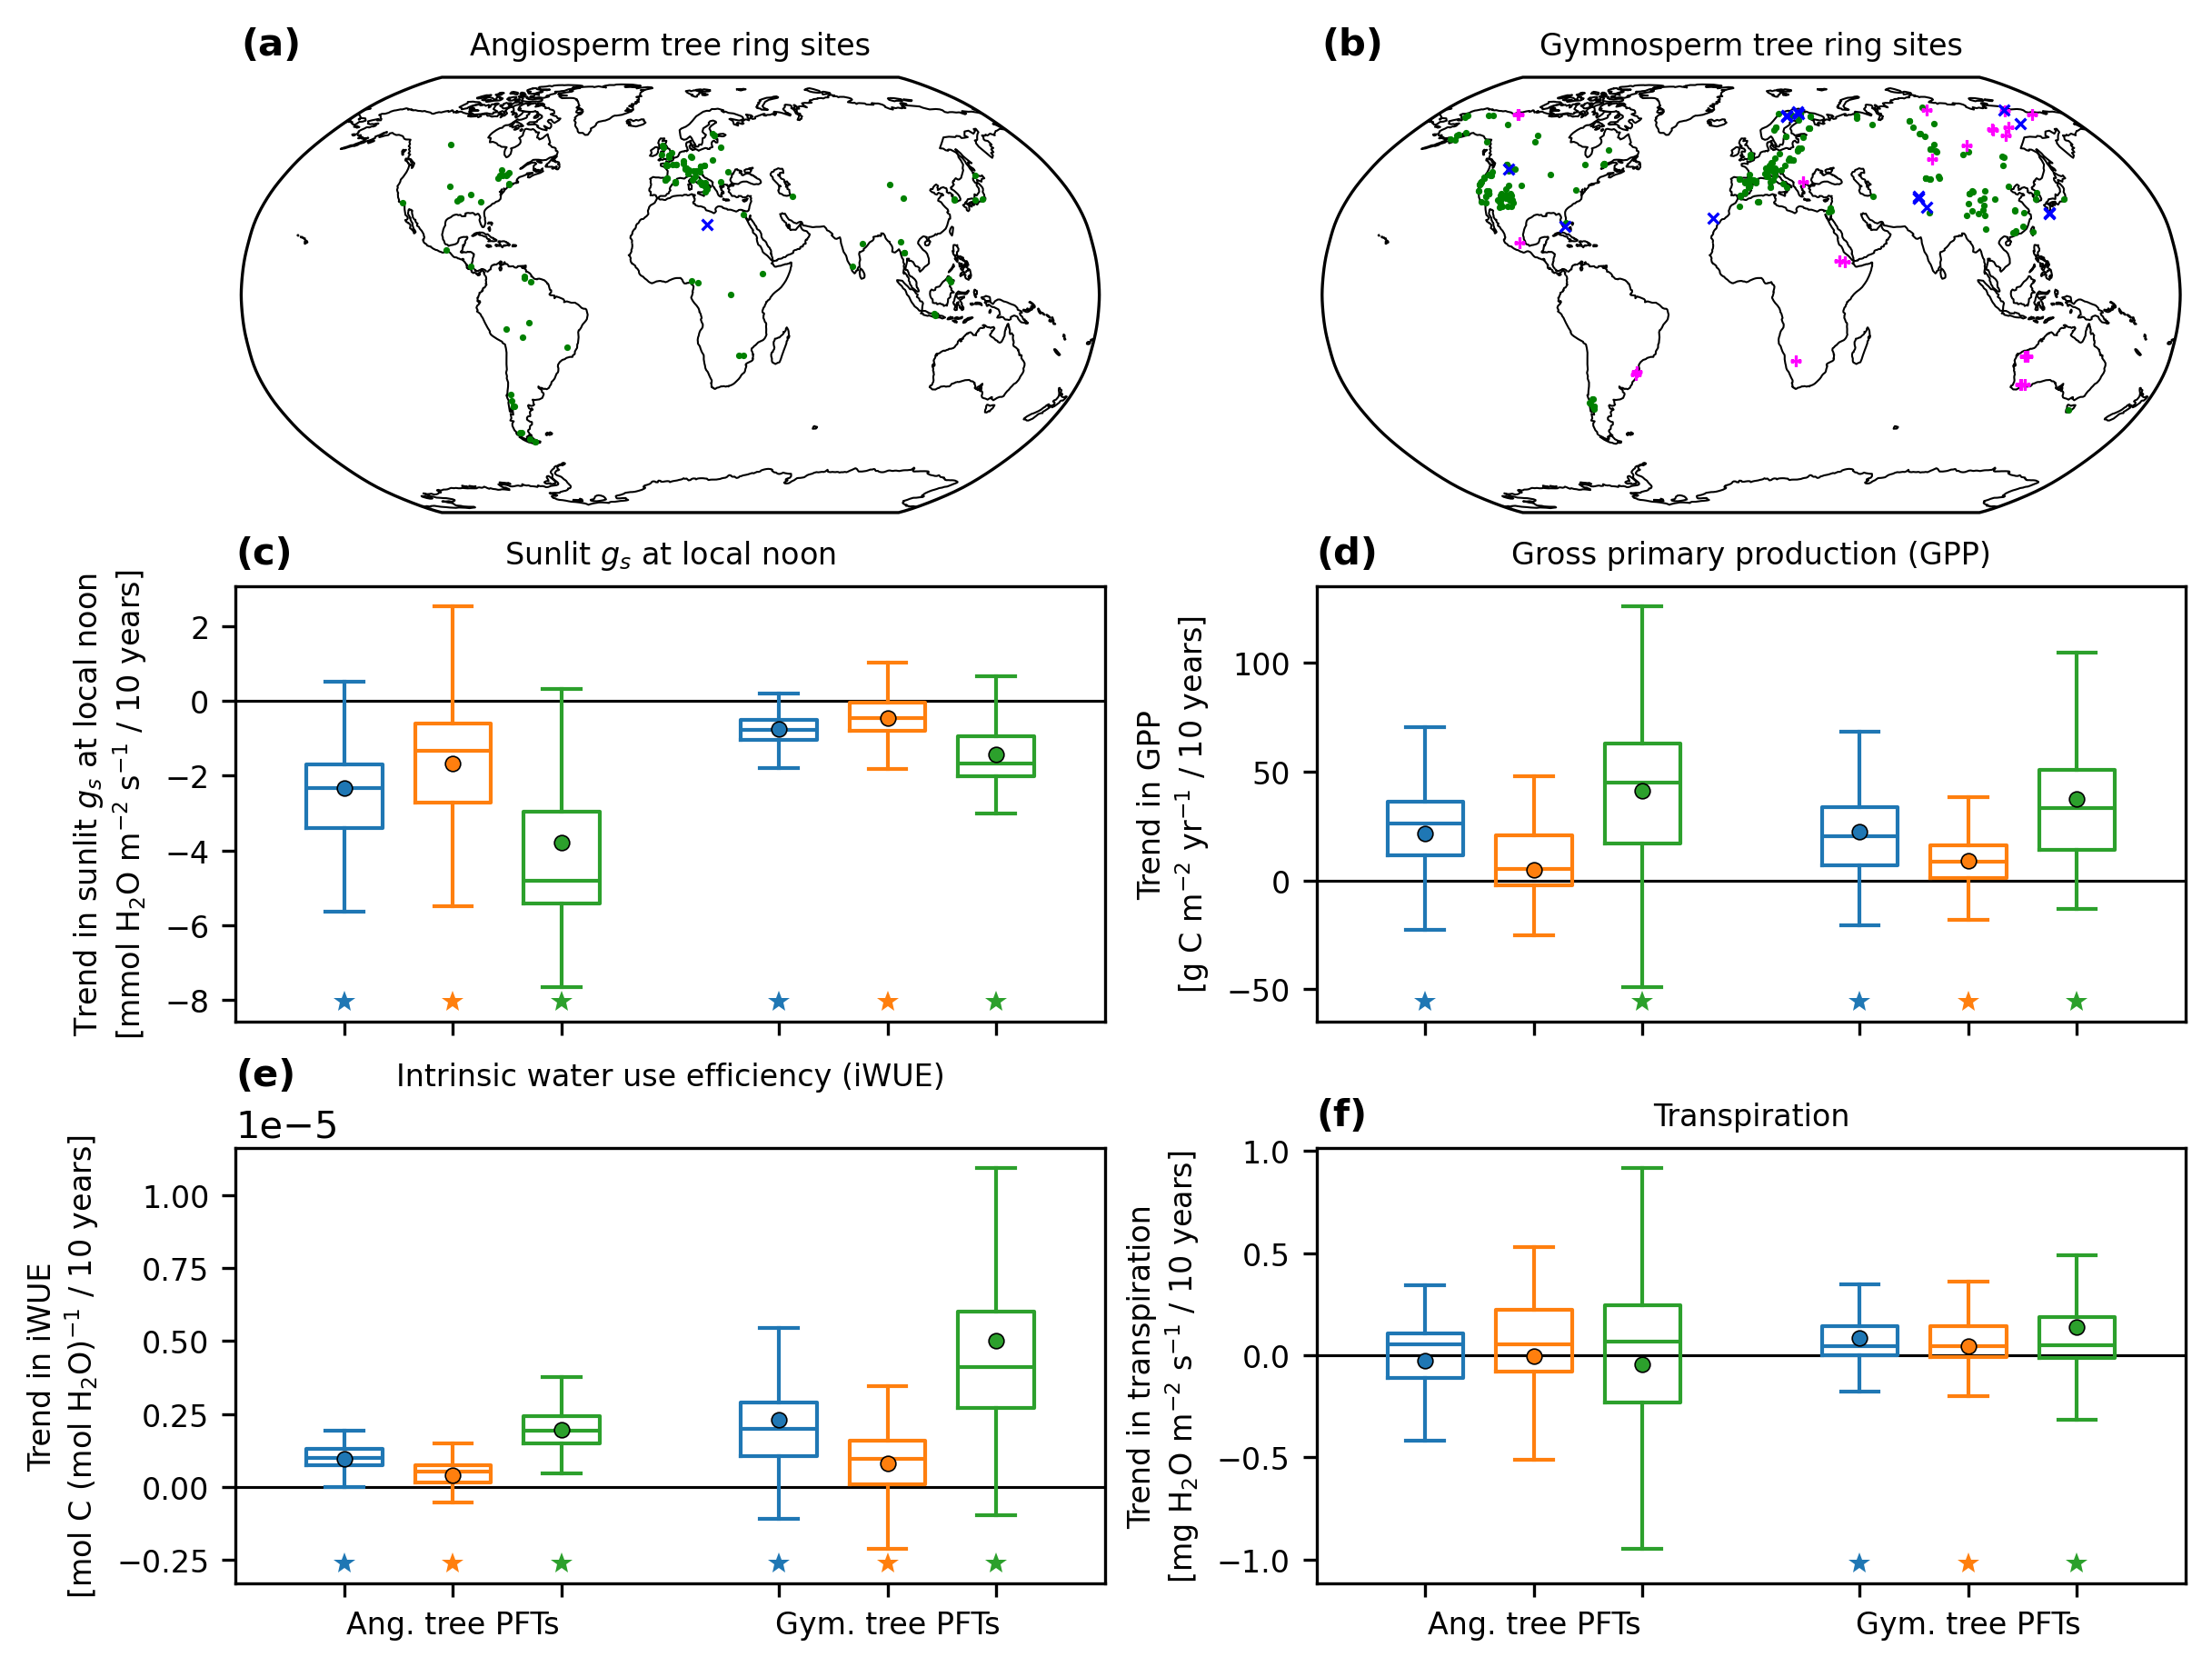

In [106]:
# Get data for boxplots
umol_to_mmol = 1/1000
gss_trend, gss_signif = format_boxplot_data(
    gssunln_full_linregress,
    gssunln_early_linregress,
    gssunln_late_linregress,
    conv_factor=umol_to_mmol,
)

s_to_year = 60 * 60 * 24 * 365
gpp_trend, gpp_signif = format_boxplot_data(
    gpp_full_linregress,
    gpp_early_linregress,
    gpp_late_linregress,
    conv_factor=s_to_year,
)

# molmol_to_gCmolH2O =  
wue_trend, wue_signif = format_boxplot_data(
    wue_full_linregress,
    wue_early_linregress,
    wue_late_linregress,
    conv_factor=1,
)

Wm2_to_mgm2s = 1000 * 1000 / 2.26e6  #  W/m2 -> mg/m2/s
tran_trend, tran_signif = format_boxplot_data(
    tran_full_linregress,
    tran_early_linregress,
    tran_late_linregress,
    conv_factor=Wm2_to_mgm2s,
)

# Set up figure
fig = plt.figure(figsize=(8, 6), constrained_layout=True)
spec = mpl.gridspec.GridSpec(ncols=2, nrows=3, figure=fig)

# Create subplots
ax1 = fig.add_subplot(spec[0, 0], projection=ccrs.Robinson())
ax2 = fig.add_subplot(spec[0, 1], projection=ccrs.Robinson())
ax3 = fig.add_subplot(spec[1, 0])
ax4 = fig.add_subplot(spec[1, 1])
ax5 = fig.add_subplot(spec[2, 0])
ax6 = fig.add_subplot(spec[2, 1])

## Plot maps

# Angiosperm trees
for i in sites_with_angtreepfts.values:
    ax1.scatter(
        tree_ring_coords.iloc[i].lon, tree_ring_coords.iloc[i].lat,
        s=3, color='green',
        marker='o', linewidth=0,
        transform=ccrs.PlateCarree()
    )

for i in sites_missing_angtreepfts.values:
    color = 'magenta'
    marker = '+'
    if i in sites_missing_treepfts.values:
        color = 'blue'
        marker = 'x'
    ax1.scatter(
        tree_ring_coords.iloc[i].lon, tree_ring_coords.iloc[i].lat,
        s=8, color=color,
        marker=marker, linewidth=0.8,
        transform=ccrs.PlateCarree()
    )
ax1.set_title(f'Angiosperm tree ring sites', fontsize=8)

# Gymnosperm trees
for i in sites_with_gymtreepfts.values:
    ax2.scatter(
        tree_ring_coords.iloc[i].lon, tree_ring_coords.iloc[i].lat,
        s=3, color='green',
        marker='o', linewidth=0,
        transform=ccrs.PlateCarree()
    )

for i in sites_missing_gymtreepfts.values:
    color = 'magenta'
    marker = '+'
    if i in sites_missing_treepfts.values:
        color = 'blue'
        marker = 'x'
    ax2.scatter(
        tree_ring_coords.iloc[i].lon, tree_ring_coords.iloc[i].lat,
        s=8, color=color,
        marker=marker, linewidth=0.8,
        transform=ccrs.PlateCarree()
    )
ax2.set_title(f'Gymnosperm tree ring sites', fontsize=8)

for a in [ax1, ax2]:
    a.set_extent((-180, 180, -90, 90))
    a.coastlines(lw=0.5, zorder=0)

## Box plots
bp = np.empty((4, 3), dtype=object)

to_showfliers = False
color = ['tab:blue', 'tab:orange', 'tab:green']
width = 0.175
position = np.array([1, 2])
pos_offset = np.array([-0.25, 0, 0.25])
xlim = np.array([0.5, 2.5])


# Plot stomatal conductance trends
ax3, bp[0] = create_boxplot(
    ax3, gss_trend,
    to_showfliers=to_showfliers,
    color=color,
    width=width,
    position=position,
    pos_offset=pos_offset,
    xlim=xlim,
)

# Plot GPP trends
ax4, bp[1] = create_boxplot(
    ax4, gpp_trend,
    to_showfliers=to_showfliers,
    color=color,
    width=width,
    position=position,
    pos_offset=pos_offset,
    xlim=xlim,
)

# Plot WUE trends
ax5, bp[2] = create_boxplot(
    ax5, wue_trend,
    to_showfliers=to_showfliers,
    color=color,
    width=width,
    position=position,
    pos_offset=pos_offset,
    xlim=xlim,
)

# Plot transpiration trends
ax6, bp[3] = create_boxplot(
    ax6, tran_trend,
    to_showfliers=to_showfliers,
    color=color,
    width=width,
    position=position,
    pos_offset=pos_offset,
    xlim=xlim,
)

## Plot stars for significance
for a, s in zip([ax3, ax4, ax5, ax6], [gss_signif, gpp_signif, wue_signif, tran_signif]):
    a = plot_significance_star(
        a, s,
        color=color,
        position=position,
        pos_offset=pos_offset,
    )

## Format boxplots
for a in [ax3, ax4, ax5, ax6]:
    a.axhline(0, -1, 3, c='k', lw=0.75, zorder=0)
    a.set_xticks([0.75, 1, 1.25, 1.75, 2, 2.25])
    a.set_xticklabels(['', '', '', '', '', ''])
    a.set_xlim(xlim[0], xlim[1])
    a.yaxis.set_tick_params(labelsize=8)

for a in [ax5, ax6]:
    a.set_xticklabels(['', 'Ang. tree PFTs', '', '', 'Gym. tree PFTs', ''], ha='center', fontsize=8)

'Trend in sunlit $g_s$ at local noon\n[mmol H$_2$O m$^{-2}$ s$^{-1}$ / 10 years]',
'Trend in GPP\n[g C m$^{-2}$ yr$^{-1}$ / 10 years]',

label_fontsize = 8
ax3.set_ylabel('Trend in sunlit $g_s$ at local noon\n[mmol H$_2$O m$^{-2}$ s$^{-1}$ / 10 years]', fontsize=label_fontsize)
ax4.set_ylabel('Trend in GPP\n[g C m$^{-2}$ yr$^{-1}$ / 10 years]', fontsize=label_fontsize)
ax5.set_ylabel('Trend in iWUE\n[mol C (mol H$_2$O)$^{-1}$ / 10 years]', fontsize=label_fontsize)
ax6.set_ylabel('Trend in transpiration\n[mg H$_2$O m$^{-2}$ s$^{-1}$ / 10 years]', fontsize=label_fontsize)

ax3.set_title('Sunlit $g_s$ at local noon', fontsize=8)
ax4.set_title('Gross primary production (GPP)', fontsize=8)
ax5.set_title('Intrinsic water use efficiency (iWUE)', fontsize=8)
ax6.set_title('Transpiration', fontsize=8)

for a, label in zip([ax1, ax2, ax3, ax4, ax5, ax6], ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']):
    a.set_title(label, fontweight='bold', loc='left', fontsize=10)

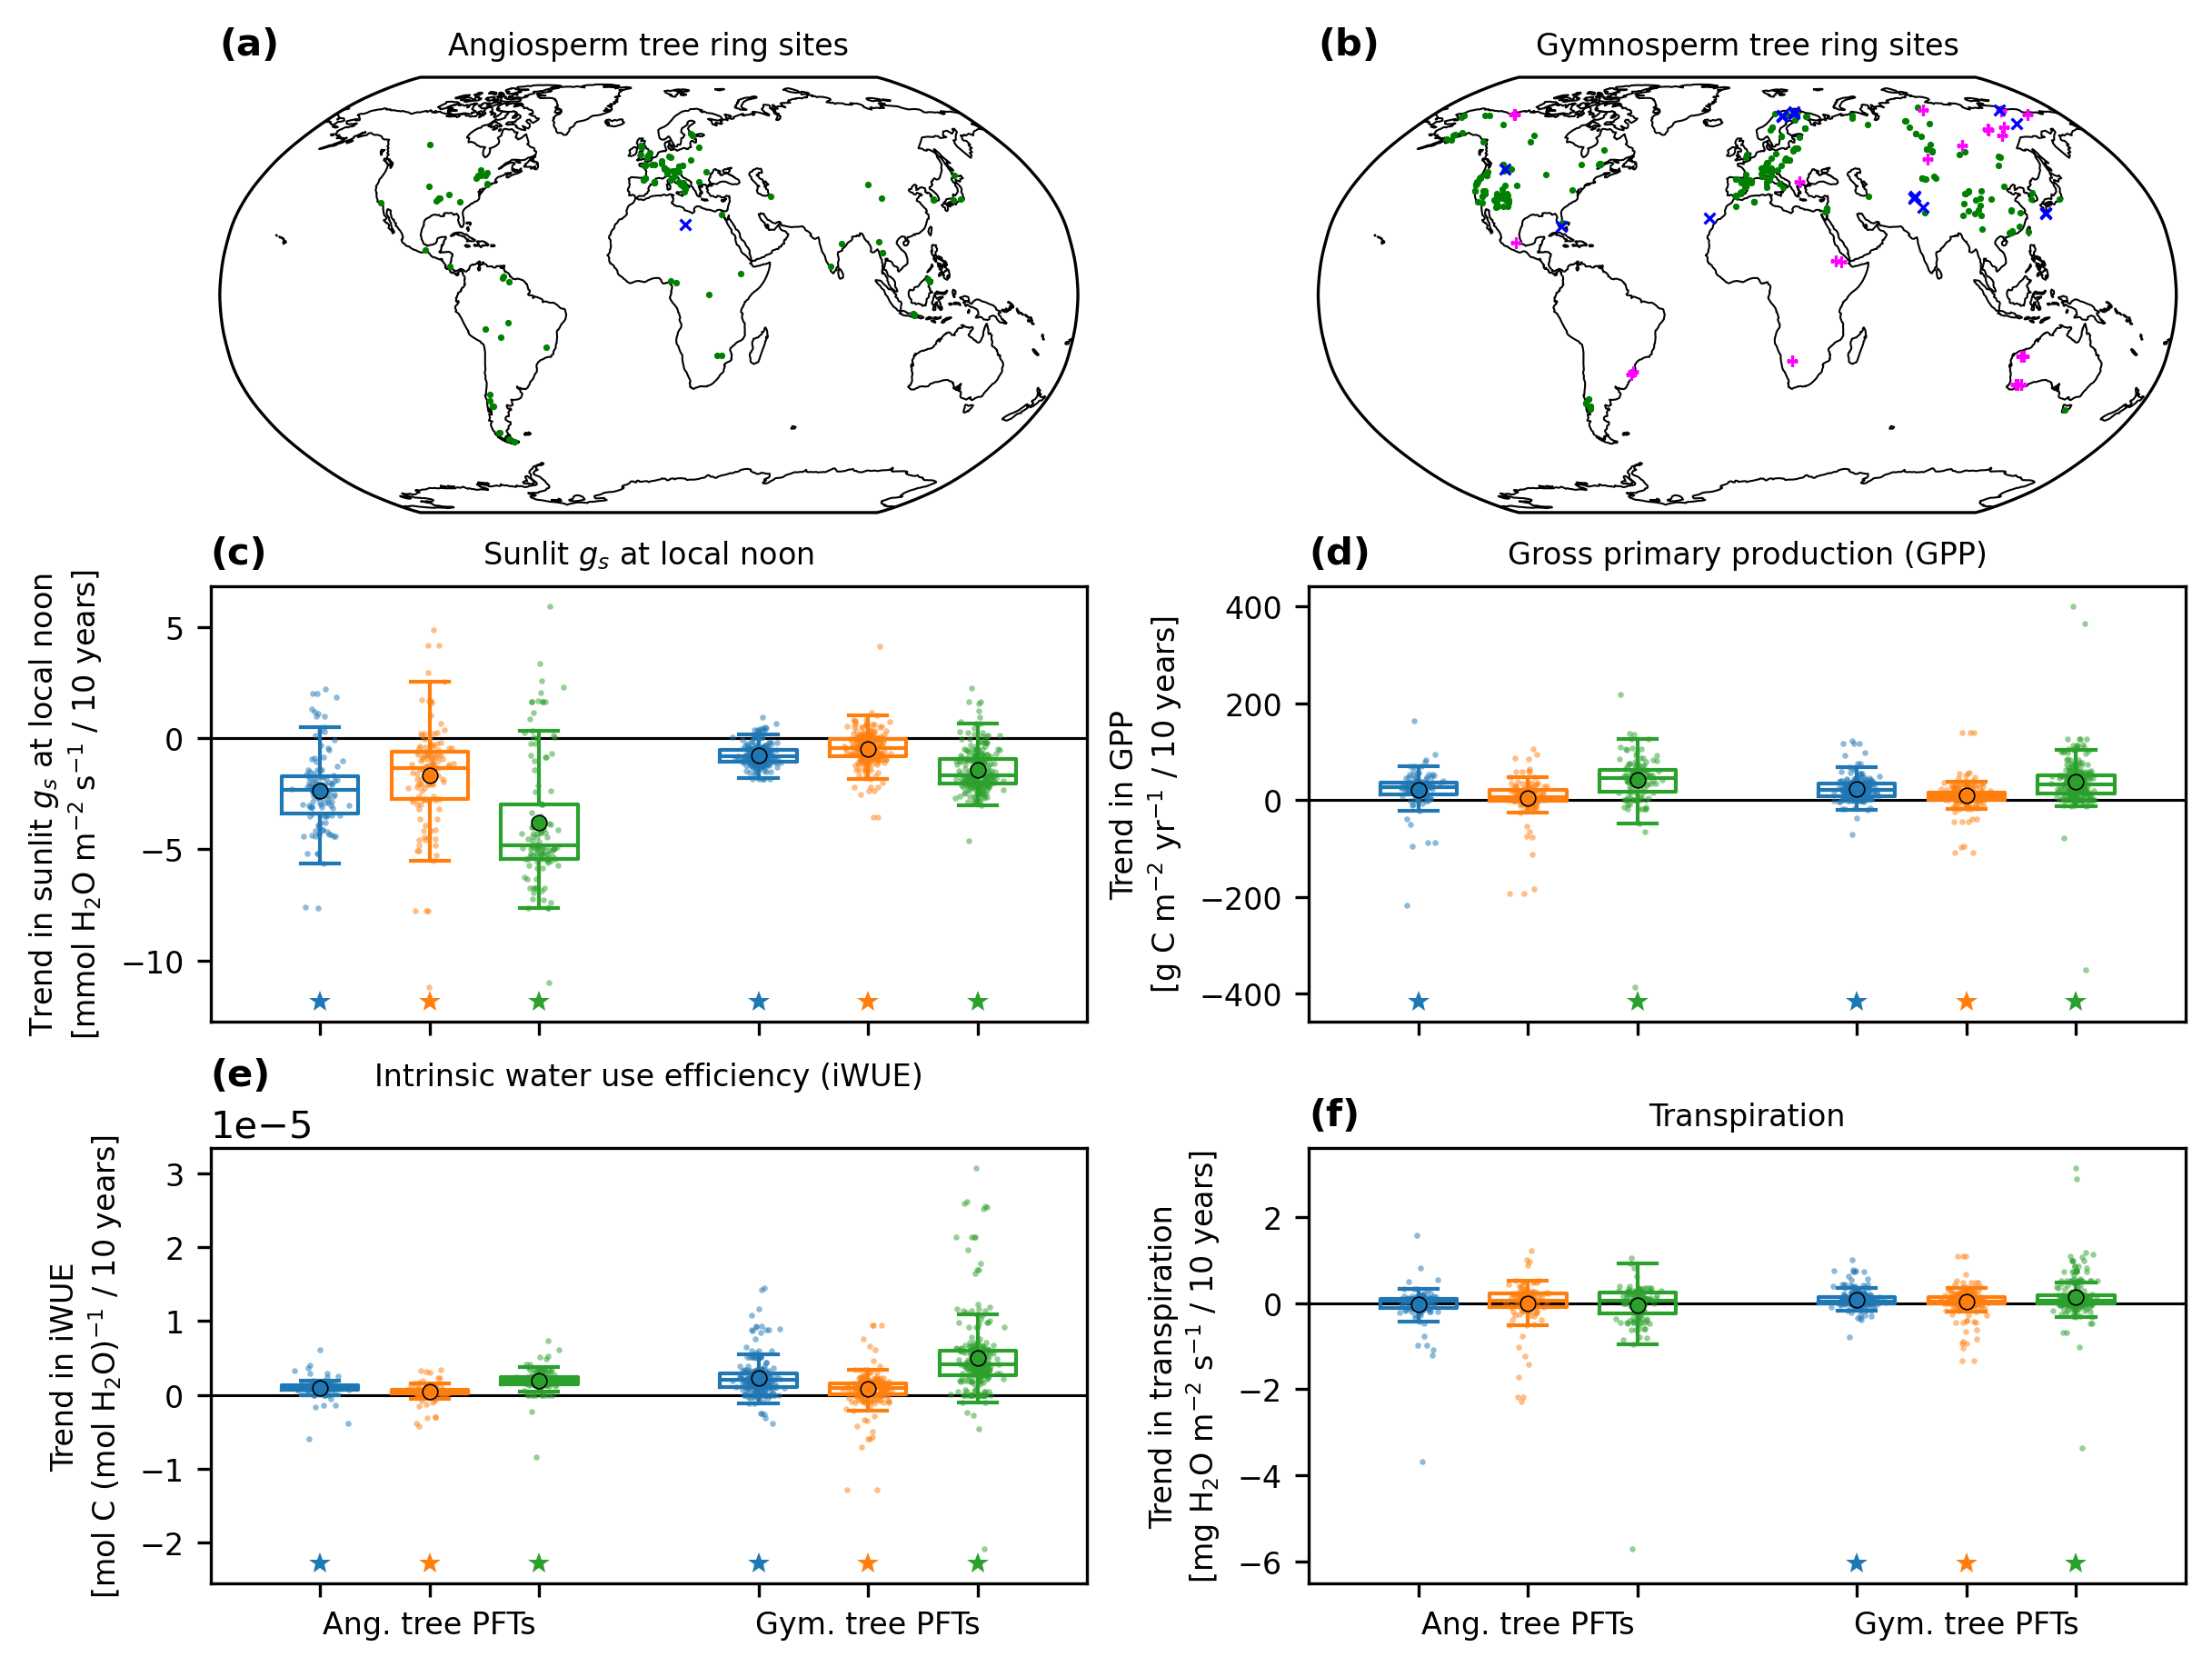

In [107]:
# Get data for boxplots
umol_to_mmol = 1/1000
gss_trend, gss_signif = format_boxplot_data(
    gssunln_full_linregress,
    gssunln_early_linregress,
    gssunln_late_linregress,
    conv_factor=umol_to_mmol,
)

s_to_year = 60 * 60 * 24 * 365
gpp_trend, gpp_signif = format_boxplot_data(
    gpp_full_linregress,
    gpp_early_linregress,
    gpp_late_linregress,
    conv_factor=s_to_year,
)

# molmol_to_gCmolH2O =  
wue_trend, wue_signif = format_boxplot_data(
    wue_full_linregress,
    wue_early_linregress,
    wue_late_linregress,
    conv_factor=1,
)

Wm2_to_mgm2s = 1000 * 1000 / 2.26e6  #  W/m2 -> mg/m2/s
tran_trend, tran_signif = format_boxplot_data(
    tran_full_linregress,
    tran_early_linregress,
    tran_late_linregress,
    conv_factor=Wm2_to_mgm2s,
)

# Set up figure
fig = plt.figure(figsize=(8, 6), constrained_layout=True)
spec = mpl.gridspec.GridSpec(ncols=2, nrows=3, figure=fig)

# Create subplots
ax1 = fig.add_subplot(spec[0, 0], projection=ccrs.Robinson())
ax2 = fig.add_subplot(spec[0, 1], projection=ccrs.Robinson())
ax3 = fig.add_subplot(spec[1, 0])
ax4 = fig.add_subplot(spec[1, 1])
ax5 = fig.add_subplot(spec[2, 0])
ax6 = fig.add_subplot(spec[2, 1])

## Plot maps

# Angiosperm trees
for i in sites_with_angtreepfts.values:
    ax1.scatter(
        tree_ring_coords.iloc[i].lon, tree_ring_coords.iloc[i].lat,
        s=3, color='green',
        marker='o', linewidth=0,
        transform=ccrs.PlateCarree()
    )

for i in sites_missing_angtreepfts.values:
    color = 'magenta'
    marker = '+'
    if i in sites_missing_treepfts.values:
        color = 'blue'
        marker = 'x'
    ax1.scatter(
        tree_ring_coords.iloc[i].lon, tree_ring_coords.iloc[i].lat,
        s=8, color=color,
        marker=marker, linewidth=0.8,
        transform=ccrs.PlateCarree()
    )
ax1.set_title(f'Angiosperm tree ring sites', fontsize=8)

# Gymnosperm trees
for i in sites_with_gymtreepfts.values:
    ax2.scatter(
        tree_ring_coords.iloc[i].lon, tree_ring_coords.iloc[i].lat,
        s=3, color='green',
        marker='o', linewidth=0,
        transform=ccrs.PlateCarree()
    )

for i in sites_missing_gymtreepfts.values:
    color = 'magenta'
    marker = '+'
    if i in sites_missing_treepfts.values:
        color = 'blue'
        marker = 'x'
    ax2.scatter(
        tree_ring_coords.iloc[i].lon, tree_ring_coords.iloc[i].lat,
        s=8, color=color,
        marker=marker, linewidth=0.8,
        transform=ccrs.PlateCarree()
    )
ax2.set_title(f'Gymnosperm tree ring sites', fontsize=8)

for a in [ax1, ax2]:
    a.set_extent((-180, 180, -90, 90))
    a.coastlines(lw=0.5, zorder=0)

## Box plots
bp = np.empty((4, 3), dtype=object)

to_showfliers = False
color = ['tab:blue', 'tab:orange', 'tab:green']
width = 0.175
position = np.array([1, 2])
pos_offset = np.array([-0.25, 0, 0.25])
xlim = np.array([0.5, 2.5])
jitter_scale = 0.02

# Plot stomatal conductance trends
ax3, bp[0] = create_boxplot(
    ax3, gss_trend,
    to_showfliers=to_showfliers,
    color=color,
    width=width,
    position=position,
    pos_offset=pos_offset,
    xlim=xlim)
ax3 = plot_scatter_with_jitter(
    ax3, gss_trend,
    jitter_scale,
    position=position,
    pos_offset=pos_offset,
    color=color)

# Plot GPP trends
ax4, bp[1] = create_boxplot(
    ax4, gpp_trend,
    to_showfliers=to_showfliers,
    color=color,
    width=width,
    position=position,
    pos_offset=pos_offset,
    xlim=xlim)
ax4 = plot_scatter_with_jitter(
    ax4, gpp_trend,
    jitter_scale,
    position=position,
    pos_offset=pos_offset,
    color=color)

# Plot WUE trends
ax5, bp[2] = create_boxplot(
    ax5, wue_trend,
    to_showfliers=to_showfliers,
    color=color,
    width=width,
    position=position,
    pos_offset=pos_offset,
    xlim=xlim)
ax5 = plot_scatter_with_jitter(
    ax5, wue_trend,
    jitter_scale,
    position=position,
    pos_offset=pos_offset,
    color=color)

# Plot transpiration trends
ax6, bp[3] = create_boxplot(
    ax6, tran_trend,
    to_showfliers=to_showfliers,
    color=color,
    width=width,
    position=position,
    pos_offset=pos_offset,
    xlim=xlim)
ax6 = plot_scatter_with_jitter(
    ax6, tran_trend,
    jitter_scale,
    position=position,
    pos_offset=pos_offset,
    color=color)

## Plot stars for significance
for a, s in zip([ax3, ax4, ax5, ax6], [gss_signif, gpp_signif, wue_signif, tran_signif]):
    a = plot_significance_star(
        a, s,
        color=color,
        position=position,
        pos_offset=pos_offset,
    )

## Format boxplots
for a in [ax3, ax4, ax5, ax6]:
    a.axhline(0, -1, 3, c='k', lw=0.75, zorder=0)
    a.set_xticks([0.75, 1, 1.25, 1.75, 2, 2.25])
    a.set_xticklabels(['', '', '', '', '', ''])
    a.set_xlim(xlim[0], xlim[1])
    a.yaxis.set_tick_params(labelsize=8)

for a in [ax5, ax6]:
    a.set_xticklabels(['', 'Ang. tree PFTs', '', '', 'Gym. tree PFTs', ''], ha='center', fontsize=8)

'Trend in sunlit $g_s$ at local noon\n[mmol H$_2$O m$^{-2}$ s$^{-1}$ / 10 years]',
'Trend in GPP\n[g C m$^{-2}$ yr$^{-1}$ / 10 years]',

label_fontsize = 8
ax3.set_ylabel('Trend in sunlit $g_s$ at local noon\n[mmol H$_2$O m$^{-2}$ s$^{-1}$ / 10 years]', fontsize=label_fontsize)
ax4.set_ylabel('Trend in GPP\n[g C m$^{-2}$ yr$^{-1}$ / 10 years]', fontsize=label_fontsize)
ax5.set_ylabel('Trend in iWUE\n[mol C (mol H$_2$O)$^{-1}$ / 10 years]', fontsize=label_fontsize)
ax6.set_ylabel('Trend in transpiration\n[mg H$_2$O m$^{-2}$ s$^{-1}$ / 10 years]', fontsize=label_fontsize)

ax3.set_title('Sunlit $g_s$ at local noon', fontsize=8)
ax4.set_title('Gross primary production (GPP)', fontsize=8)
ax5.set_title('Intrinsic water use efficiency (iWUE)', fontsize=8)
ax6.set_title('Transpiration', fontsize=8)

for a, label in zip([ax1, ax2, ax3, ax4, ax5, ax6], ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']):
    a.set_title(label, fontweight='bold', loc='left', fontsize=10)

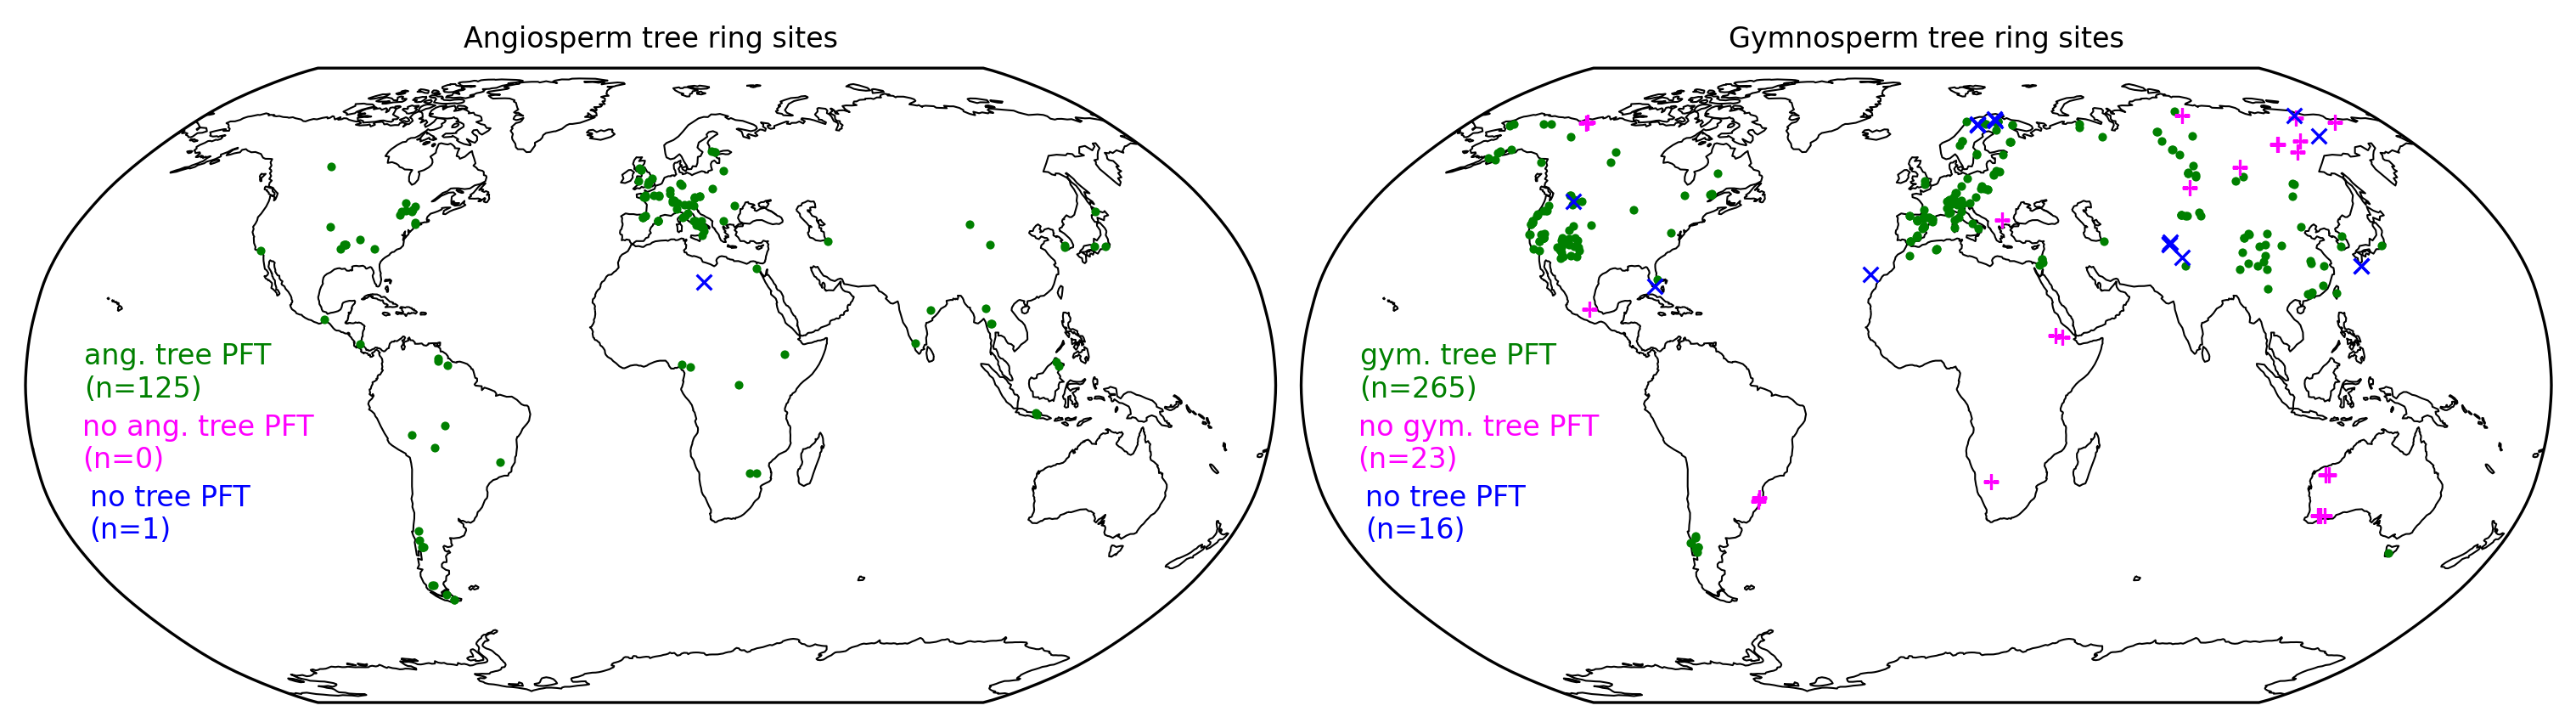

In [25]:
fig, axes = plt.subplots(
    1, 2,
    figsize=(10,3),
    layout='constrained',
    subplot_kw={'projection': ccrs.Robinson()}
)
ax1 = axes[0]
ax2 = axes[1]

small_markersize = 6
large_markersize = 18

# Angiosperm trees
for i in sites_with_angtreepfts.values:
    ax1.scatter(
        tree_ring_coords.iloc[i].lon, tree_ring_coords.iloc[i].lat,
        s=small_markersize, color='green',
        marker='o', linewidth=0,
        transform=ccrs.PlateCarree()
    )

n = 0
for i in sites_missing_angtreepfts.values:
    color = 'magenta'
    marker = '+'
    if i in sites_missing_treepfts.values:
        n += 1
        color = 'blue'
        marker = 'x'
    ax1.scatter(
        tree_ring_coords.iloc[i].lon, tree_ring_coords.iloc[i].lat,
        s=large_markersize, color=color,
        marker=marker, linewidth=0.8,
        transform=ccrs.PlateCarree()
    )
ax1.set_title(f'Angiosperm tree ring sites', fontsize=8)
ax1.text(-164, 11, f'ang. tree PFT\n(n={sites_with_angtreepfts.size})', color='green', fontsize=8, va='top', transform=ccrs.PlateCarree())
ax1.text(-164, -7, f'no ang. tree PFT\n(n={sites_missing_angtreepfts.size-n})', color='magenta', fontsize=8, va='top', transform=ccrs.PlateCarree())
ax1.text(-166, -25, f'no tree PFT\n(n={n})', color='blue', fontsize=8,  va='top', transform=ccrs.PlateCarree())

# Gymnosperm trees
for i in sites_with_gymtreepfts.values:
    ax2.scatter(
        tree_ring_coords.iloc[i].lon, tree_ring_coords.iloc[i].lat,
        s=small_markersize, color='green',
        marker='o', linewidth=0,
        transform=ccrs.PlateCarree()
    )

n = 0
for i in sites_missing_gymtreepfts.values:
    color = 'magenta'
    marker = '+'
    if i in sites_missing_treepfts.values:
        n += 1
        color = 'blue'
        marker = 'x'
    ax2.scatter(
        tree_ring_coords.iloc[i].lon, tree_ring_coords.iloc[i].lat,
        s=large_markersize, color=color,
        marker=marker, linewidth=0.8,
        transform=ccrs.PlateCarree()
    )
ax2.set_title(f'Gymnosperm tree ring sites', fontsize=8)
ax2.text(-164, 11, f'gym. tree PFT\n(n={sites_with_gymtreepfts.size})', color='green', fontsize=8, va='top', transform=ccrs.PlateCarree())
ax2.text(-164, -7, f'no gym. tree PFT\n(n={sites_missing_gymtreepfts.size-n})', color='magenta', fontsize=8, va='top', transform=ccrs.PlateCarree())
ax2.text(-166, -25, f'no tree PFT\n(n={n})', color='blue', fontsize=8,  va='top', transform=ccrs.PlateCarree())

for a in [ax1, ax2]:
    a.set_extent((-180, 180, -90, 90))
    a.coastlines(lw=0.5, zorder=0)

[Text(1.0, 0, 'angLOW'),
 Text(1.4, 0, 'gymLOW'),
 Text(2.0, 0, 'angDEF'),
 Text(2.4, 0, 'gymDEF'),
 Text(3.0, 0, 'angHIGH'),
 Text(3.4, 0, 'gymHIGH')]

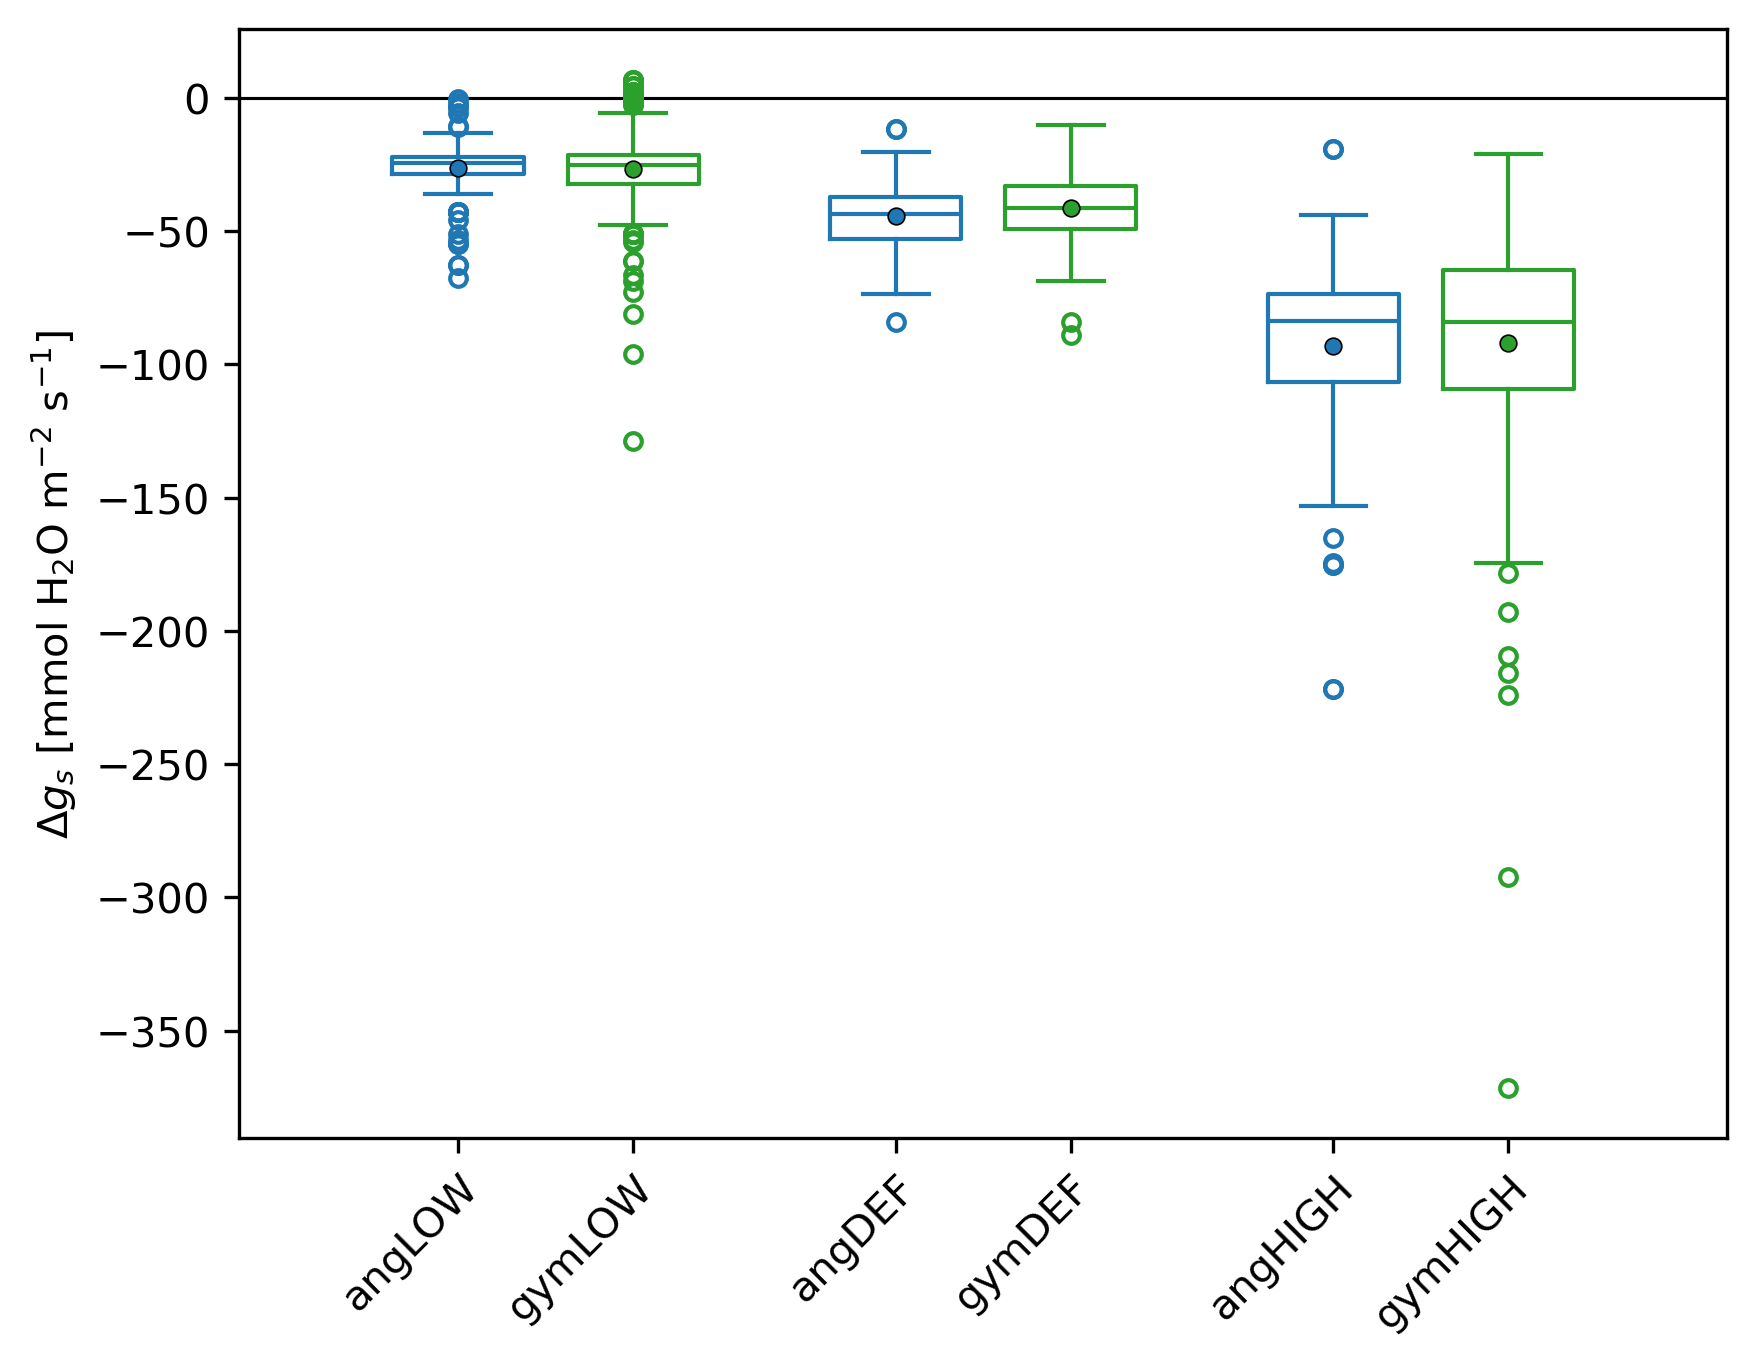

In [26]:
medslope_names = ['LOW', 'DEF', 'HIGH']
var = 'GSSUNLN'
da_list = []
for this_slope in medslope_names:
    ds = xr.open_dataset(f'/glade/work/bbuchovecky/WUE_analysis/medslope/{var}.coupled_{this_slope}medslope_2xCO2-1xCO2.nc')
    da_list.append(ds[var].copy())
da = xr.concat(da_list, dim='medslope').assign_coords({'medslope': np.arange(3)})

conv_factor = 1/1000

fig, ax = plt.subplots()
width = 0.2
to_showfliers = True
color = ['tab:blue', 'tab:green']
positions = np.array([1,2,3])
pos_offset = 0.4

bp = np.empty((2), dtype=object)

ax.axhline(0, 0, 4, lw=0.75, c='k')

bp[0] = ax.boxplot(
    [da.isel(medslope=0).isel(site=sites_with_angtreepfts)*conv_factor,
     da.isel(medslope=1).isel(site=sites_with_angtreepfts)*conv_factor,
     da.isel(medslope=2).isel(site=sites_with_angtreepfts)*conv_factor],
    positions=positions,
    showmeans=True,
);

bp[1] = ax.boxplot(
    [da.isel(medslope=0).isel(site=sites_with_gymtreepfts)*conv_factor,
     da.isel(medslope=1).isel(site=sites_with_gymtreepfts)*conv_factor,
     da.isel(medslope=2).isel(site=sites_with_gymtreepfts)*conv_factor],
    positions=positions+pos_offset,
    showmeans=True
);

for j, this_bp in enumerate(bp):
    for i,box in enumerate(this_bp['boxes']):
        box.set(linewidth=1, color=color[j])

    for i,med in enumerate(this_bp['medians']):
        med.set(linewidth=1, color=color[j])
    
    for i,whsk in enumerate(this_bp['whiskers']):
        whsk.set(linewidth=1, color=color[j])

    for i, (whsk, mean) in enumerate(zip(this_bp['whiskers'][1::2], this_bp['means'])):
        mean.set(marker='o', markerfacecolor=color[j], markeredgewidth=0.4, markeredgecolor='k', markersize=4)

    for i,cap in enumerate(this_bp['caps']):
        cap.set(linewidth=1, color=color[j])
    
    if to_showfliers:
        for i,flier in enumerate(this_bp['fliers']):
            flier.set(marker='o', markeredgecolor=color[j], markersize=4)

ax.set_ylabel('$\Delta g_s$ [mmol H$_2$O m$^{-2}$ s$^{-1}$]')
ax.set_xticks(sorted(list(positions)+list(positions+pos_offset)))
ax.set_xticklabels(['angLOW', 'gymLOW', 'angDEF', 'gymDEF', 'angHIGH', 'gymHIGH'],
    rotation=45, ha='right', rotation_mode='anchor')

[Text(1.0, 0, 'angLOW'),
 Text(1.4, 0, 'gymLOW'),
 Text(2.0, 0, 'angDEF'),
 Text(2.4, 0, 'gymDEF'),
 Text(3.0, 0, 'angHIGH'),
 Text(3.4, 0, 'gymHIGH')]

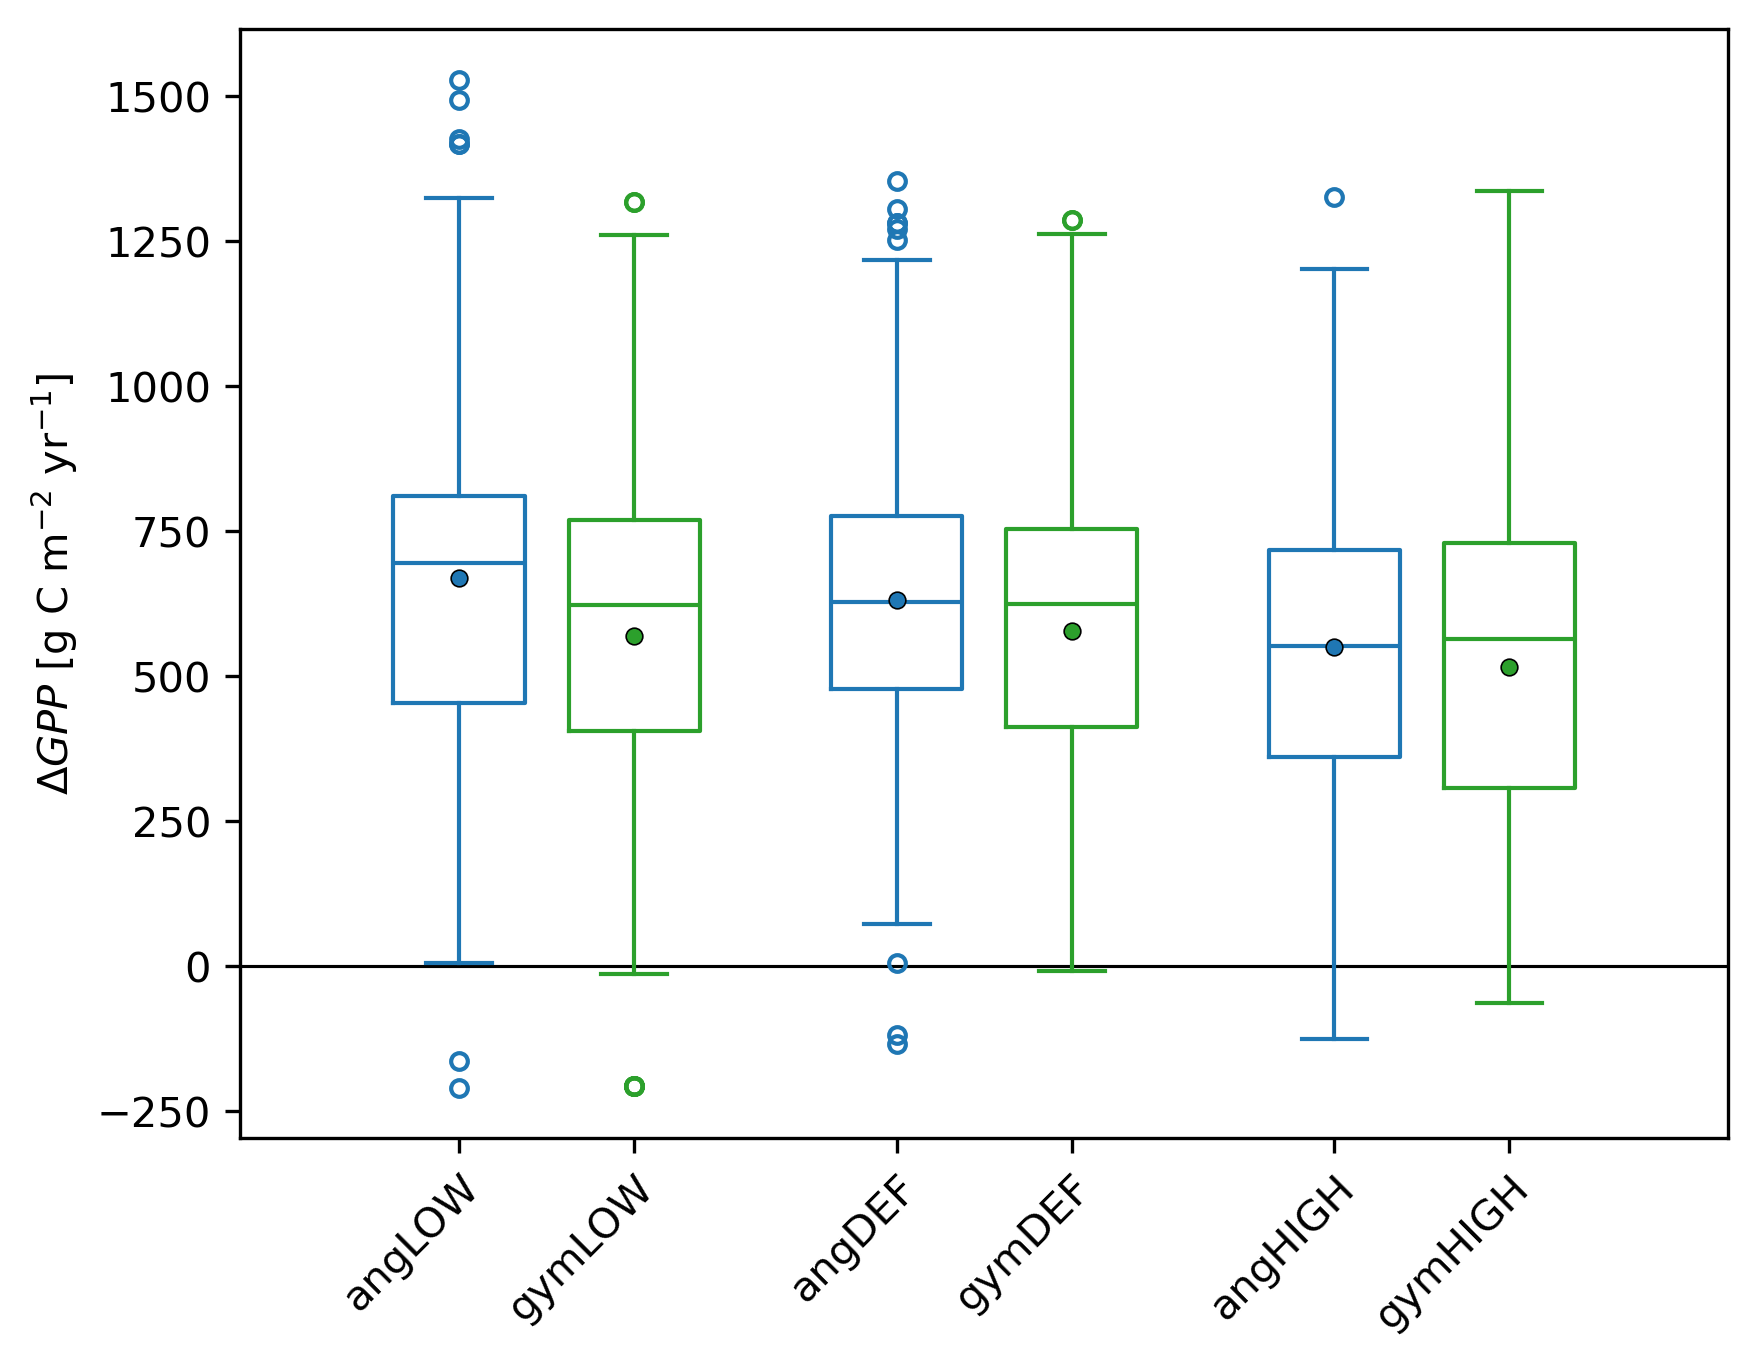

In [27]:
medslope_names = ['LOW', 'DEF', 'HIGH']
var = 'GPP'
da_list = []
for this_slope in medslope_names:
    ds = xr.open_dataset(f'/glade/work/bbuchovecky/WUE_analysis/medslope/{var}.coupled_{this_slope}medslope_2xCO2-1xCO2.nc')
    da_list.append(ds[var].copy())
da = xr.concat(da_list, dim='medslope', coords='minimal').assign_coords({'medslope': np.arange(3)})

conv_factor = 60 * 60 * 24 * 365

fig, ax = plt.subplots()
width = 0.2
to_showfliers = True
color = ['tab:blue', 'tab:green']
positions = np.array([1,2,3])
pos_offset = 0.4

bp = np.empty((2), dtype=object)

ax.axhline(0, 0, 4, lw=0.75, c='k')

bp[0] = ax.boxplot(
    [da.isel(medslope=0).isel(site=sites_with_angtreepfts)*conv_factor,
     da.isel(medslope=1).isel(site=sites_with_angtreepfts)*conv_factor,
     da.isel(medslope=2).isel(site=sites_with_angtreepfts)*conv_factor],
    positions=positions,
    showmeans=True,
);

bp[1] = ax.boxplot(
    [da.isel(medslope=0).isel(site=sites_with_gymtreepfts)*conv_factor,
     da.isel(medslope=1).isel(site=sites_with_gymtreepfts)*conv_factor,
     da.isel(medslope=2).isel(site=sites_with_gymtreepfts)*conv_factor],
    positions=positions+pos_offset,
    showmeans=True
);

for j, this_bp in enumerate(bp):
    for i,box in enumerate(this_bp['boxes']):
        box.set(linewidth=1, color=color[j])

    for i,med in enumerate(this_bp['medians']):
        med.set(linewidth=1, color=color[j])
    
    for i,whsk in enumerate(this_bp['whiskers']):
        whsk.set(linewidth=1, color=color[j])

    for i, (whsk, mean) in enumerate(zip(this_bp['whiskers'][1::2], this_bp['means'])):
        mean.set(marker='o', markerfacecolor=color[j], markeredgewidth=0.4, markeredgecolor='k', markersize=4)

    for i,cap in enumerate(this_bp['caps']):
        cap.set(linewidth=1, color=color[j])
    
    if to_showfliers:
        for i,flier in enumerate(this_bp['fliers']):
            flier.set(marker='o', markeredgecolor=color[j], markersize=4)

ax.set_ylabel('$\Delta GPP$ [g C m$^{-2}$ yr$^{-1}$]')
ax.set_xticks(sorted(list(positions)+list(positions+pos_offset)))
ax.set_xticklabels(['angLOW', 'gymLOW', 'angDEF', 'gymDEF', 'angHIGH', 'gymHIGH'],
    rotation=45, ha='right', rotation_mode='anchor')